# Galería de modelo prueba para aplicación Deep Leaves


## Librerías

In [1]:
# Librerías de manipulación de datos y visualización
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import ImageFile
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
import joblib

# Librerías de Sklearn
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision.transforms import v2 as transforms
from torchvision.datasets import ImageFolder
from torch.utils.tensorboard import SummaryWriter
import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights

## Rutas
Rutas que se usan de manera transversal en el código 

In [2]:
# paths
path="Data/"
modelo_resnet50 = "Modelos/resnet50.pth"
modelo_cnn_ruta = "Modelos/cnn_gpu.pth"
modelo_mobilenet_ruta = "Modelos/modelo_entrenado_mobilenetv1_norm.pth"
modelo_mobilenetv2_ruta = "Modelos/modelo_entrenado_mobilenetv2_norm.pth"
model_randomforest_save_path = 'Modelos/modelo_randomforest.pkl'

## Lectura y limpieza
Se dividen los datos en Train (Entrenamiento) y Val (Validación) de manera aleatoria en una división de 70% para entrenamiento donde los datos pueden ser alterados con rotaciones, cambios de color y al final se normalizan (Se dejan con un intervalo de colores); 30% para validación sin alterar

In [3]:
# Definir transformaciones de datos para el conjunto de entrenamiento y validación
transform_train = transforms.Compose([
    transforms.ToImage(),
    transforms.RandomRotation(35),
    transforms.RandomResizedCrop(224, antialias=True), 
    transforms.RandomHorizontalFlip(),
    #transforms.RandomPhotometricDistort(p=0.10),
    transforms.ToDtype(torch.float32, scale=True),
    #transforms.RandomIoUCrop(),
    #transforms.ColorJitter(brightness=0, contrast=0.2, saturation=0.01, hue=0),
    transforms.Normalize(mean=[0.35, 0.35, 0.35], std=[0.3, 0.3, 0.3]),
])

transform_val = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize(224, antialias=None), 
    #transforms.CenterCrop(224),
    transforms.ToDtype(torch.float32, scale=True),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Directorio de datos
data_directory = os.path.join(path)

# Crear el conjunto de datos utilizando ImageFolder
dataset = torchvision.datasets.ImageFolder(
    root=data_directory,
    transform=transform_train
)

# Dividir el conjunto de datos en conjuntos de entrenamiento 70% y validación 30%
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Crear DataLoader para el conjunto de entrenamiento y validación
train_loader = DataLoader(train_dataset, batch_size=36, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=36, shuffle=False)

# Obtener el número total de clases
num_classes = len(dataset.classes)

# Obtener el número total de muestras de entrenamiento
num_train_samples = len(train_dataset)

# Obtener el número total de muestras de validación
num_validation_samples = len(val_dataset)

# Obtener las clases originales a partir de los nombres de las carpetas
class_names = dataset.classes


### Verificar

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

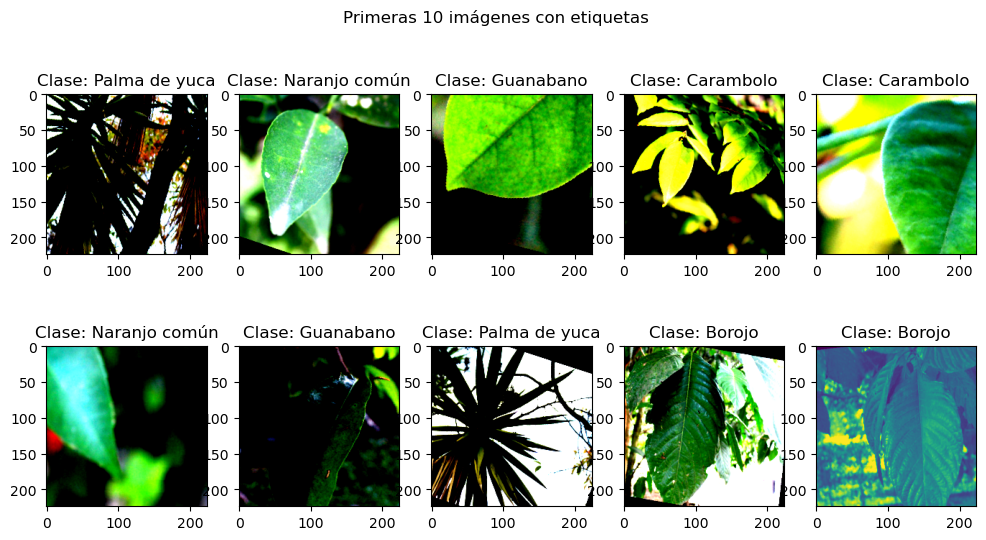

In [25]:
# Obtener un lote de datos de entrenamiento
for batch_images, batch_labels in train_loader:
   break

# Visualizar las primeras 10 imágenes con sus etiquetas
num_images_to_show = 10

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle('Primeras 10 imágenes con etiquetas')

for i in range(num_images_to_show):
   image = batch_images[i].permute(1, 2, 0).numpy() # Cambiar dimensiones para visualización
   label = int(batch_labels[i].item())

   axes[i // 5, i % 5].imshow(image)
   axes[i // 5, i % 5].set_title(f'Clase: {class_names[label]}')

for channel in range(3):
    axes[i // 5, i % 5].imshow(image[:, :, channel])

plt.show()

In [5]:
#Verificar
print(class_names)
print(num_classes)
print(num_train_samples)
print(num_validation_samples)

['Borojo', 'Carambolo', 'Guanabano', 'Naranjo común', 'Palma de yuca']
5
34911
14962


## Resnet50 Finetunnig

In [4]:
# Definir el modelo
# Best available weights (currently alias for IMAGENET1K_V2)
# Note that these weights may change across versions, Actual accuracy 80.858%
model = resnet50(weights=ResNet50_Weights.DEFAULT)

# Modificar la capa de salida para adaptarla a 5 clases
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)  # 5 clases en tu conjunto de datos

# Verificar la estructura del modelo modificado
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Entrenamiento 

In [5]:
# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Número de épocas (iteraciones completas sobre el conjunto de datos)
num_epochs = 20

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Mover el modelo a la GPU si está disponible
model.to(device)

# Entrenamiento y evaluación del modelo
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validar el modelo
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Accuracy: {accuracy}')

# Guardar el modelo entrenado
torch.save(model.state_dict(), modelo_resnet50)

print('Entrenamiento completado.')

Epoch 1/20, Validation Accuracy: 0.9266809250100254
Epoch 2/20, Validation Accuracy: 0.9953214810854164
Epoch 3/20, Validation Accuracy: 0.9327629995989841
Epoch 4/20, Validation Accuracy: 0.9891725705119636
Epoch 5/20, Validation Accuracy: 0.9774762732255046
Epoch 6/20, Validation Accuracy: 0.8663948669963909
Epoch 7/20, Validation Accuracy: 0.9972597246357439
Epoch 8/20, Validation Accuracy: 0.9929822216281246
Epoch 9/20, Validation Accuracy: 0.9933832375350888
Epoch 10/20, Validation Accuracy: 0.9941184333645234
Epoch 11/20, Validation Accuracy: 0.996056676914851
Epoch 12/20, Validation Accuracy: 0.9967250367597915
Epoch 13/20, Validation Accuracy: 0.9940515973800295
Epoch 14/20, Validation Accuracy: 0.9945862852559818
Epoch 15/20, Validation Accuracy: 0.9956556610078866
Epoch 16/20, Validation Accuracy: 0.9987301162946131
Epoch 17/20, Validation Accuracy: 0.836719689881032
Epoch 18/20, Validation Accuracy: 0.9985296083411309
Epoch 19/20, Validation Accuracy: 0.993516909504077
Epoch

### Cargar modelo

In [4]:
# Carga el modelo Resnet50
model_r50 = resnet50(weights=None)

# Modificar la capa de salida para adaptarla a 5 clases
num_ftrs = model_r50.fc.in_features
model_r50.fc = nn.Linear(num_ftrs, 5)  # 5 clases en tu conjunto de datos

# Cargar los pesos guardados en el modelo
model_r50.load_state_dict(torch.load(modelo_resnet50))

<All keys matched successfully>

In [5]:
# 10 Epochs mas con norm
# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_r50.parameters(), lr=0.001)

# Número de épocas (iteraciones completas sobre el conjunto de datos)
num_epochs = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Mover el modelo a la GPU si está disponible
model_r50.to(device)

# Entrenamiento y evaluación del modelo
for epoch in range(num_epochs):
    model_r50.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_r50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validar el modelo
    model_r50.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_r50(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Accuracy: {accuracy}')

# Guardar el modelo entrenado
torch.save(model_r50.state_dict(), modelo_resnet50)

print('Entrenamiento completado.')

Epoch 1/10, Validation Accuracy: 0.9976607405427081
Epoch 2/10, Validation Accuracy: 0.9989306242480952
Epoch 3/10, Validation Accuracy: 0.9981954284186606
Epoch 4/10, Validation Accuracy: 0.9985296083411309
Epoch 5/10, Validation Accuracy: 0.9993316401550595
Epoch 6/10, Validation Accuracy: 0.9959230049458628
Epoch 7/10, Validation Accuracy: 0.9979949204651785
Epoch 8/10, Validation Accuracy: 0.9957224969923807
Epoch 9/10, Validation Accuracy: 0.9985964443256249
Epoch 10/10, Validation Accuracy: 0.9989974602325892
Entrenamiento completado.


### Eval resnet50

In [7]:
#RESNET50
# Mover el modelo a la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_r50.to(device)

# Evaluar el modelo en el conjunto de validación
with torch.no_grad():
    true_labels_val = []
    predicted_labels_val = []

    for inputs_val, labels_val in val_loader:
        inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)  # Mover datos a la GPU si es necesario
        outputs_val = model_r50(inputs_val)
        _, predicted_val = torch.max(outputs_val, 1)
        true_labels_val.extend(labels_val.cpu().numpy())
        predicted_labels_val.extend(predicted_val.cpu().numpy())

# Calcular el classification_report en el conjunto de validación
reporte_clasificacion = classification_report(true_labels_val, predicted_labels_val, target_names=class_names)

# Calcular la matriz de confusión
matriz_confusion = confusion_matrix(true_labels_val, predicted_labels_val)

# Imprimir el classification_report y la matriz de confusión
print("Reporte de Clasificación en el conjunto de validación:")
print(reporte_clasificacion)

print("\nMatriz de Confusión:")
print(matriz_confusion)

Reporte de Clasificación en el conjunto de validación:
               precision    recall  f1-score   support

       Borojo       1.00      1.00      1.00      2956
    Carambolo       0.99      1.00      1.00      2961
    Guanabano       1.00      1.00      1.00      3041
Naranjo común       1.00      0.99      1.00      2964
Palma de yuca       1.00      1.00      1.00      3040

     accuracy                           1.00     14962
    macro avg       1.00      1.00      1.00     14962
 weighted avg       1.00      1.00      1.00     14962


Matriz de Confusión:
[[2948    3    5    0    0]
 [   0 2960    0    1    0]
 [   2    5 3032    1    1]
 [   1   19    6 2938    0]
 [   0    1    2    1 3036]]


### AUC y ROC

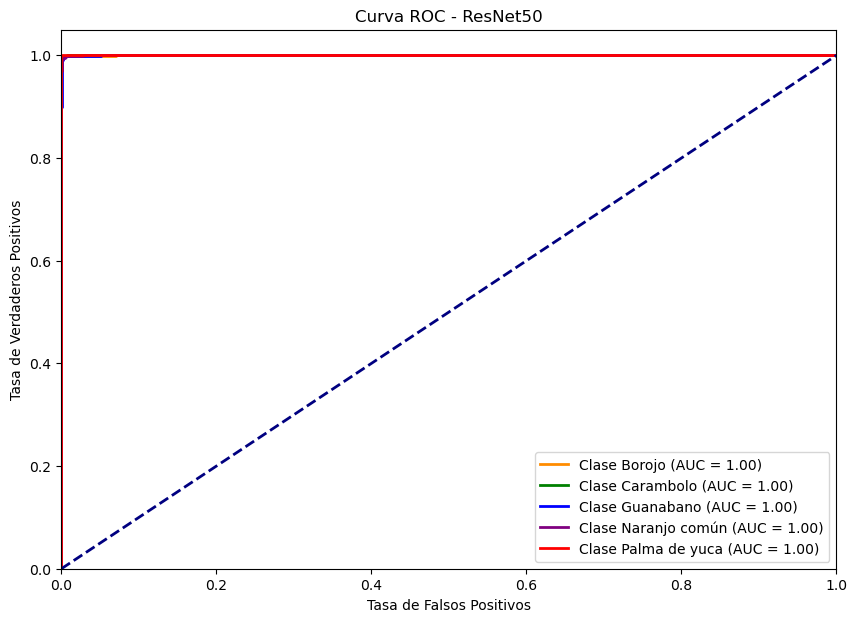

In [11]:
# Evaluar el modelo en el conjunto de validación para obtener las probabilidades de predicción
model_r50.eval()
prob_predictions_model_r50 = []

with torch.no_grad():
    for inputs_val, _ in val_loader:
        inputs_val = inputs_val.to(device)
        outputs_val = model_r50(inputs_val)
        prob_predictions_model_r50.extend(outputs_val.cpu().numpy())

# Obtener las etiquetas reales (y_true) de los datos de prueba
y_true = true_labels_val  

# Convertir la lista a un array de numpy
prob_predictions_model_r50 = np.array(prob_predictions_model_r50)

# Calcular la curva ROC y el AUC para cada clase y modelo
fpr_model_r50 = dict()
tpr_model_r50 = dict()
roc_auc_model_r50 = dict()

for i in range(num_classes):
    fpr_model_r50[i], tpr_model_r50[i], _ = roc_curve(y_true, prob_predictions_model_r50[:, i], pos_label=i)
    roc_auc_model_r50[i] = auc(fpr_model_r50[i], tpr_model_r50[i])
    
# Crear el gráfico ROC para el modelo
plt.figure(figsize=(10, 7))
colors = ['darkorange', 'green', 'blue', 'purple', 'red']  # Colores para las clases
for i in range(num_classes):
    plt.plot(fpr_model_r50[i], tpr_model_r50[i], color=colors[i], lw=2, label=f'Clase {class_names[i]} (AUC = {roc_auc_model_r50[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - ResNet50')
plt.legend(loc='lower right')
plt.show()

# Random Forest
Es un conjunto de árboles de decisión. Cada árbol se entrena en una submuestra de datos y realiza predicciones individuales. Luego, las predicciones de cada árbol se promedian o votan para obtener la predicción final.
La hace pesada, pero eficaz para tareas en específico (Clasificación y Regresión); en este caso clasifica de una CNN resnet quien le presta los features.
Su extracción de características es limitada en comparación con modelos especializados en visión por computadora 

## Features y modelo resnet18

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cargar una ResNet pre-entrenada y moverla a la GPU si está disponible
resnet_model = models.resnet18(pretrained=True).to(device)
# Quitar la capa de clasificación final (capa completamente conectada)
resnet_model = nn.Sequential(*list(resnet_model.children())[:-1])
# Establecer el modelo en modo de evaluación (no se entrenarán los parámetros)
resnet_model.eval()

# Definir una función para extraer características
def extract_features(loader, model):
    features = []
    labels = []
    for images, targets in loader:
        with torch.no_grad():
            # Mover las imágenes a la GPU si está disponible
            images = images.to(device)
            # Pasar las imágenes a través del modelo pre-entrenado
            outputs = model(images)
            # Obtener las características de la penúltima capa (antes de la capa completamente conectada)
            features.extend(outputs.squeeze().cpu().numpy())
            # Guardar las etiquetas
            labels.extend(targets.cpu().numpy())
    return features, labels

# Extraer características para el conjunto de entrenamiento y validación
train_features, train_labels = extract_features(train_loader, resnet_model)
val_features, val_labels = extract_features(val_loader, resnet_model)



In [14]:
# Crear un clasificador de Random Forest, n_estimators es el numero de arboles 
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenar el clasificador con las características y etiquetas de entrenamiento
rf_classifier.fit(train_features, train_labels)

# Guardar el modelo entrenado en la ruta 'Modelos/modelo_randomforest'
model_randomforest_save_path = 'Modelos/modelo_randomforest.pkl'
joblib.dump(rf_classifier, model_randomforest_save_path)

# Evaluar el rendimiento en el conjunto de validación
val_predictions = rf_classifier.predict(val_features)
accuracy = accuracy_score(val_labels, val_predictions)
print(f'Accuracy on validation set: {accuracy * 100:.2f}%')


Accuracy on validation set: 94.93%


## Cargar RandomForest

In [22]:
# Cargar el modelo RandomForest desde el archivo guardado
model_randomforest = joblib.load('Modelos/modelo_randomforest.pkl')


## Eval RandomForest

Accuracy (Validation) - RandomForest: 0.9493
Precision (Validation) - RandomForest: 0.9501
Recall (Validation) - RandomForest: 0.9493
F1-score (Validation) - RandomForest: 0.9494
Confusion Matrix - RandomForest:
[[2876   11   16   47    6]
 [   2 2856   50  105    1]
 [  17  157 2663  142    0]
 [   9  123   66 2765    0]
 [   5    0    0    2 3043]]


<Figure size 1000x1000 with 0 Axes>

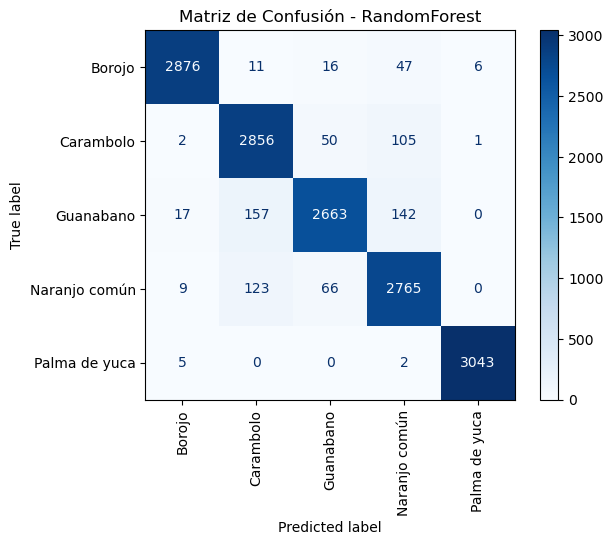

In [23]:
# Inicializa listas para almacenar etiquetas verdaderas y predicciones en el conjunto de validación
true_labels_val_rf = []
predicted_labels_val_rf = []

# Evaluar el modelo RandomForest en el conjunto de validación
predicted_labels_val_rf = model_randomforest.predict(val_features)

# Calcular métricas en el conjunto de validación
accuracy_val_rf = accuracy_score(val_labels, predicted_labels_val_rf)
precision_val_rf = precision_score(val_labels, predicted_labels_val_rf, average='weighted')
recall_val_rf = recall_score(val_labels, predicted_labels_val_rf, average='weighted')
f1_val_rf = f1_score(val_labels, predicted_labels_val_rf, average='weighted')

# Calcular la matriz de confusión
conf_matrix_rf = confusion_matrix(val_labels, predicted_labels_val_rf)

# Imprimir métricas en el conjunto de validación
print(f'Accuracy (Validation) - RandomForest: {accuracy_val_rf:.4f}')
print(f'Precision (Validation) - RandomForest: {precision_val_rf:.4f}')
print(f'Recall (Validation) - RandomForest: {recall_val_rf:.4f}')
print(f'F1-score (Validation) - RandomForest: {f1_val_rf:.4f}')

# Imprimir la matriz de confusión
print('Confusion Matrix - RandomForest:')
print(conf_matrix_rf)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 10))
display_rf = ConfusionMatrixDisplay(conf_matrix_rf, display_labels=class_names)
display_rf.plot(cmap='Blues', values_format='d', xticks_rotation='vertical')
plt.title('Matriz de Confusión - RandomForest')
plt.show()


## ROC Y AUC Randomforest

AUC (Class Borojo): 0.9990
AUC (Class Carambolo): 0.9939
AUC (Class Guanabano): 0.9938
AUC (Class Naranjo común): 0.9950
AUC (Class Palma de yuca): 1.0000
Macro-AUC: 0.9964
Micro-AUC: 0.9971


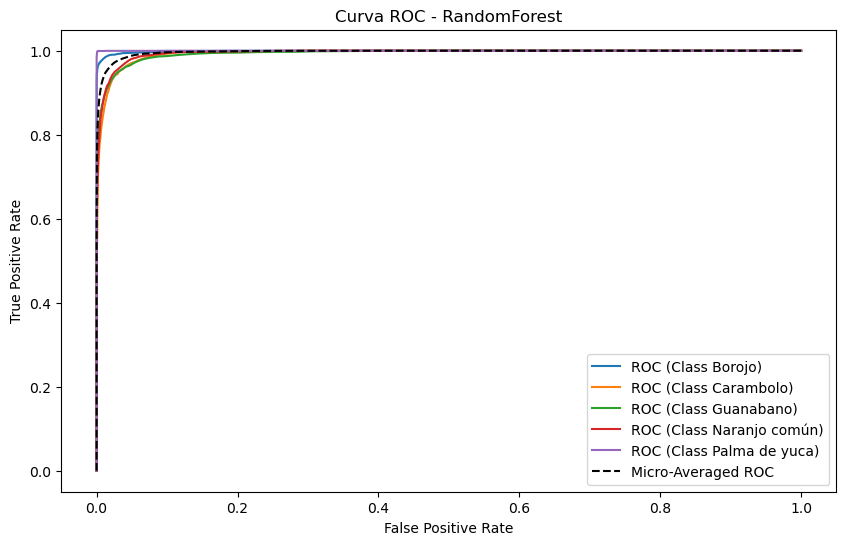

In [24]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Obtener las probabilidades de predicción en lugar de las clases
predicted_scores_val_rf = model_randomforest.predict_proba(val_features)

# Binarizar las etiquetas verdaderas
true_labels_val_bin = label_binarize(val_labels, classes=range(num_classes))

# Inicializar variables para almacenar la tasa de falsos positivos, la tasa de verdaderos positivos y el AUC
fpr_rf = dict()
tpr_rf = dict()
roc_auc_rf = dict()

# Calcular la curva ROC para cada clase y el AUC
for i in range(num_classes):
    fpr_rf[i], tpr_rf[i], _ = roc_curve(true_labels_val_bin[:, i], predicted_scores_val_rf[:, i])
    roc_auc_rf[class_names[i]] = auc(fpr_rf[i], tpr_rf[i])
    print(f'AUC (Class {class_names[i]}): {roc_auc_rf[class_names[i]]:.4f}')

# Calcular el macro-promedio del AUC
roc_auc_macro_rf = np.mean(list(roc_auc_rf.values()))
print(f'Macro-AUC: {roc_auc_macro_rf:.4f}')

# Calcular el micro-AUC
fpr_micro_rf, tpr_micro_rf, _ = roc_curve(true_labels_val_bin.ravel(), predicted_scores_val_rf.ravel())
roc_auc_micro_rf = auc(fpr_micro_rf, tpr_micro_rf)
print(f'Micro-AUC: {roc_auc_micro_rf:.4f}')

# Visualizar la curva ROC
plt.figure(figsize=(10, 6))

# Graficar las curvas ROC para cada clase
for i in range(num_classes):
    plt.plot(fpr_rf[i], tpr_rf[i], label=f'ROC (Class {class_names[i]})')

# Graficar la curva ROC micro-promedio
plt.plot(fpr_micro_rf, tpr_micro_rf, label='Micro-Averaged ROC', linestyle='--', color='black')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - RandomForest')
plt.legend()
plt.show()


# MobileNetV1
MobileNetV1 utiliza capas de convolución separable en profundidad, que consisten en una convolución en la que cada canal de entrada tiene su propia convolución (depthwise convolution) seguida de una convolución punto a punto (pointwise convolution). Esto reduce la cantidad de parámetros y operaciones, haciéndola más eficiente en términos computacionales.
1. Depthwise Convolution:
   - En la etapa de convolución en profundidad, MobileNetV1 aplica un filtro separado para cada canal de entrada, lo que significa que cada canal tiene su propio conjunto de pesos para procesar la información.
   - Esto reduce significativamente la cantidad de parámetros en comparación con las convoluciones tradicionales, donde un solo filtro se aplica a través de todos los canales, lo que resulta en una mayor eficiencia en términos de almacenamiento y cálculos.

3. Pointwise Convolution:
   - Después de la convolución en profundidad, se realiza una convolución punto a punto para combinar la información de los canales individuales y crear
   representaciones más ricas y complejas.
   - La convolución punto a punto utiliza un kernel 1x1 para mezclar las características extraídas por la convolución en profundidad, permitiendo una interacción más compleja entre los canales.

In [59]:
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride, padding=1, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class MobileNetV1(nn.Module):
    def __init__(self, num_classes=5, dropout_prob=0.5):
        super(MobileNetV1, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            DepthwiseSeparableConv(32, 64, 1),
            nn.ReLU(inplace=True),
            DepthwiseSeparableConv(64, 128, 2),
            nn.ReLU(inplace=True),
            DepthwiseSeparableConv(128, 128, 1),
            nn.ReLU(inplace=True),
            DepthwiseSeparableConv(128, 256, 2),
            nn.ReLU(inplace=True),
            DepthwiseSeparableConv(256, 256, 1),
            nn.ReLU(inplace=True),
            DepthwiseSeparableConv(256, 512, 2),
            nn.ReLU(inplace=True),
            DepthwiseSeparableConv(512, 512, 1),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(dropout_prob) # Regularización

    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Configurar el modelo, la función de pérdida y el optimizador
model = MobileNetV1(num_classes=5)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001) 

# Mover el modelo a la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Configurar TensorBoard para el registro de eventos
writer = SummaryWriter()

# Callback para el registro de eventos en TensorBoard
class TensorBoardCallback:
    def __init__(self, writer):
        self.writer = writer

    def __call__(self, epoch, loss, accuracy):
        self.writer.add_scalar('Loss', loss, epoch)
        self.writer.add_scalar('Accuracy', accuracy, epoch)

# Número de épocas
num_epochs = 40

# Historial para almacenar métricas de entrenamiento
history = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}

# Callback para el historial
class HistoryCallback:
    def __init__(self, history):
        self.history = history

    def __call__(self, epoch, train_loss, val_loss, val_accuracy):
        self.history['train_loss'].append(train_loss)
        self.history['val_loss'].append(val_loss)
        self.history['val_accuracy'].append(val_accuracy)

# Bucle de entrenamiento
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        # Mover los datos a la GPU
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Calcular la precisión en el conjunto de validación
    model.eval()
    correct = 0
    total = 0
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            # Mover los datos a la GPU
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            val_loss += criterion(outputs, labels).item()

    accuracy = correct / total
    val_loss /= len(val_loader)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Validation Accuracy: {accuracy:.2%}')

    # Guardar el modelo después de cada época
    torch.save(model.state_dict(), modelo_mobilenet_ruta)

    # Registrar eventos en TensorBoard
    writer.add_scalar('Loss', loss.item(), epoch)
    writer.add_scalar('Accuracy', accuracy, epoch)

    # Registrar métricas en el historial
    history['train_loss'].append(loss.item())
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(accuracy)

# Guardar el modelo completo al final del entrenamiento
torch.save(model, modelo_mobilenet_ruta)

# Cerrar TensorBoard
writer.close()

print('Entrenamiento completado.')

Epoch [1/40], Loss: 1.2296, Validation Accuracy: 56.30%
Epoch [2/40], Loss: 0.8036, Validation Accuracy: 69.53%
Epoch [3/40], Loss: 1.0437, Validation Accuracy: 77.90%
Epoch [4/40], Loss: 0.3767, Validation Accuracy: 82.26%
Epoch [5/40], Loss: 0.2410, Validation Accuracy: 84.64%
Epoch [6/40], Loss: 0.1083, Validation Accuracy: 86.28%
Epoch [7/40], Loss: 0.2232, Validation Accuracy: 90.09%
Epoch [8/40], Loss: 0.3838, Validation Accuracy: 90.44%
Epoch [9/40], Loss: 0.1950, Validation Accuracy: 90.03%
Epoch [10/40], Loss: 0.2219, Validation Accuracy: 93.66%
Epoch [11/40], Loss: 0.2045, Validation Accuracy: 94.19%
Epoch [12/40], Loss: 0.1159, Validation Accuracy: 93.51%
Epoch [13/40], Loss: 0.0747, Validation Accuracy: 94.99%
Epoch [14/40], Loss: 0.0969, Validation Accuracy: 93.96%
Epoch [15/40], Loss: 0.0895, Validation Accuracy: 95.34%
Epoch [16/40], Loss: 0.1792, Validation Accuracy: 95.88%
Epoch [17/40], Loss: 0.0985, Validation Accuracy: 95.48%
Epoch [18/40], Loss: 0.3747, Validation 

In [61]:
# Cargar modelo       

class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride, padding=1, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class MobileNetV1(nn.Module):
    def __init__(self, num_classes=5):
        super(MobileNetV1, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            DepthwiseSeparableConv(32, 64, 1),
            nn.ReLU(inplace=True),
            DepthwiseSeparableConv(64, 128, 2),
            nn.ReLU(inplace=True),
            DepthwiseSeparableConv(128, 128, 1),
            nn.ReLU(inplace=True),
            DepthwiseSeparableConv(128, 256, 2),
            nn.ReLU(inplace=True),
            DepthwiseSeparableConv(256, 256, 1),
            nn.ReLU(inplace=True),
            DepthwiseSeparableConv(256, 512, 2),
            nn.ReLU(inplace=True),
            DepthwiseSeparableConv(512, 512, 1),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
        
model = torch.load(modelo_mobilenet_ruta)
model.eval()

MobileNetV1(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): DepthwiseSeparableConv(
      (depthwise): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32)
      (pointwise): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
    )
    (3): ReLU(inplace=True)
    (4): DepthwiseSeparableConv(
      (depthwise): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64)
      (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
    )
    (5): ReLU(inplace=True)
    (6): DepthwiseSeparableConv(
      (depthwise): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=128)
      (pointwise): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
    )
    (7): ReLU(inplace=True)
    (8): DepthwiseSeparableConv(
      (depthwise): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=128)
      (pointwise): Conv2d(12

## Eval Mobilenetv1

Accuracy (Validation): 0.9840
Precision (Validation): 0.9842
Recall (Validation): 0.9840
F1-score (Validation): 0.9840
Confusion Matrix:
[[2870    3   20   15    6]
 [   1 2880   33   20    1]
 [   2    9 2968   14    0]
 [   6   49   57 2835    0]
 [   2    1    0    0 3170]]


<Figure size 1000x1000 with 0 Axes>

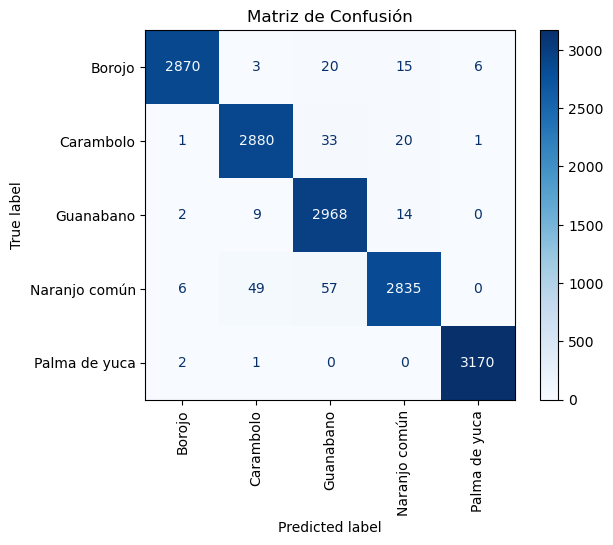

In [62]:
# Mover el modelo a la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Inicializa listas para almacenar etiquetas verdaderas y predicciones en el conjunto de validación
true_labels_val = []
predicted_labels_val = []

# Evaluar el modelo en el conjunto de validación
model.eval()
with torch.no_grad():
    for inputs_val, labels_val in val_loader:
        inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)  # Mover datos a la GPU si es necesario
        outputs_val = model(inputs_val)
        _, predicted_val = torch.max(outputs_val, 1)
        true_labels_val.extend(labels_val.cpu().numpy())
        predicted_labels_val.extend(predicted_val.cpu().numpy())

# Calcular métricas en el conjunto de validación
accuracy_val = accuracy_score(true_labels_val, predicted_labels_val)
precision_val = precision_score(true_labels_val, predicted_labels_val, average='weighted')
recall_val = recall_score(true_labels_val, predicted_labels_val, average='weighted')
f1_val = f1_score(true_labels_val, predicted_labels_val, average='weighted')

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(true_labels_val, predicted_labels_val)

# Imprimir métricas en el conjunto de validación
print(f'Accuracy (Validation): {accuracy_val:.4f}')
print(f'Precision (Validation): {precision_val:.4f}')
print(f'Recall (Validation): {recall_val:.4f}')
print(f'F1-score (Validation): {f1_val:.4f}')

# Imprimir la matriz de confusión
print('Confusion Matrix:')
print(conf_matrix)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 10))
display = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
display.plot(cmap='Blues', values_format='d', xticks_rotation='vertical')
plt.title('Matriz de Confusión')
plt.show()

## ROC y AUC Mobilenetv1

AUC (Class Borojo): 0.5160
AUC (Class Carambolo): 0.5062
AUC (Class Guanabano): 0.4981
AUC (Class Naranjo común): 0.5062
AUC (Class Palma de yuca): 0.4866
Micro-AUC: 0.5026


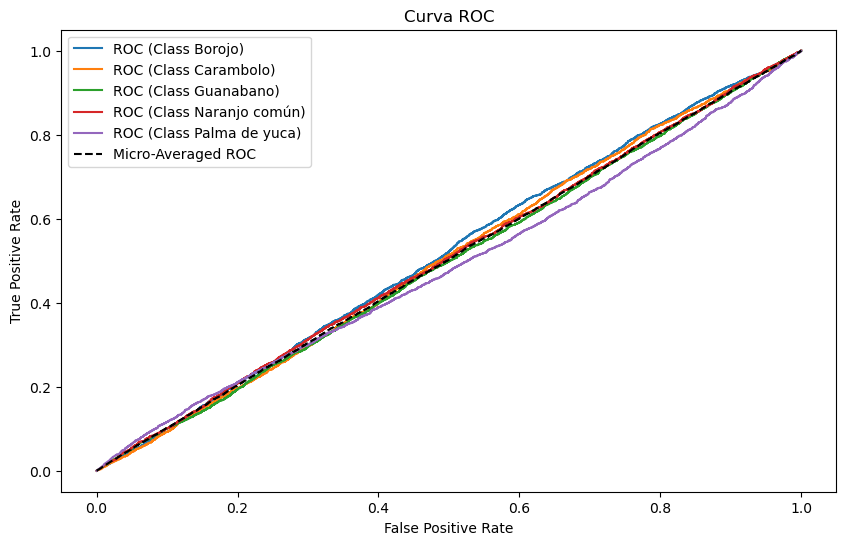

In [18]:
# Mover el modelo a la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Inicializa listas para almacenar etiquetas verdaderas y predicciones en el conjunto de validación
true_labels_val = []
predicted_scores_val = []  # Las probabilidades predichas en lugar de las clases

# Evaluar el modelo en el conjunto de validación
with torch.no_grad():
    for inputs_val, labels_val in val_loader:
        inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
        outputs_val = model(inputs_val)
        _, predicted_val = torch.max(outputs_val, 1)
        true_labels_val.extend(labels_val.cpu().numpy())
        for i in range(num_classes):
            predicted_scores_val.extend(torch.nn.functional.softmax(outputs_val, dim=1)[:, i].cpu().numpy())

# Calcule la curva ROC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve((np.array(true_labels_val) == i).astype(int), np.array(predicted_scores_val)[i::num_classes])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calcular el micro-promedio de la curva ROC y el AUC
fpr_micro, tpr_micro, _ = roc_curve(np.eye(num_classes)[np.array(true_labels_val)].ravel(), np.array(predicted_scores_val).ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Imprimir AUC por clase
for i in range(num_classes):
    print(f'AUC (Class {class_names[i]}): {roc_auc[i]:.4f}')

# Imprimir AUC micro-promedio
print(f'Micro-AUC: {roc_auc_micro:.4f}')

# Visualizar la curva ROC
plt.figure(figsize=(10, 6))

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC (Class {class_names[i]})')

plt.plot(fpr_micro, tpr_micro, label='Micro-Averaged ROC', linestyle='--', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend()
#plt.xlim([0.0, 0.2])  
#plt.ylim([0.8, 1.0])  
#plt.xscale('log')
plt.show()


AUC (Class Borojo): 0.9997
AUC (Class Carambolo): 0.9993
AUC (Class Guanabano): 0.9989
AUC (Class Naranjo común): 0.9990
AUC (Class Palma de yuca): 1.0000
Macro-AUC: 0.9994
Micro-AUC: 0.9994


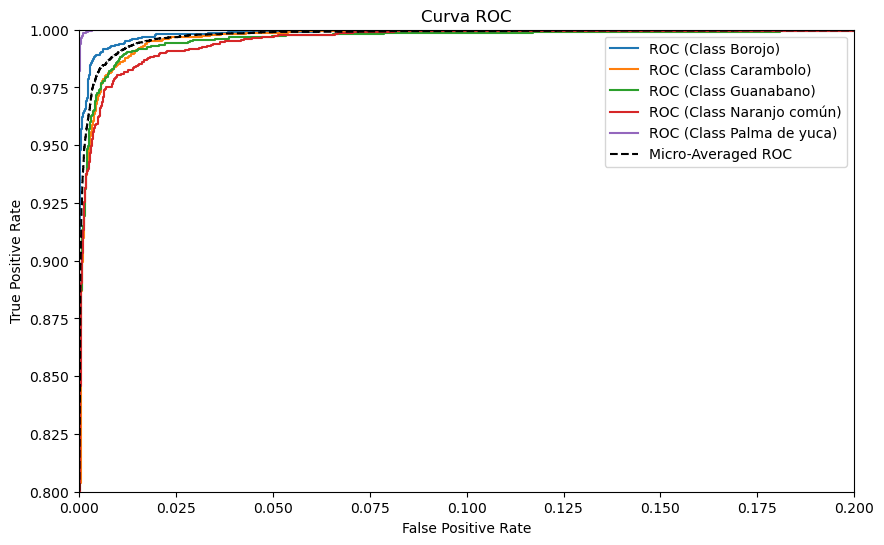

In [25]:
# Mover el modelo a la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Inicializar listas para almacenar etiquetas verdaderas y predicciones en el conjunto de validación
true_labels_val = []
predicted_scores_val = []  # Probabilidades predichas en lugar de las clases

# Evaluar el modelo en el conjunto de validación
with torch.no_grad():
    for inputs_val, labels_val in val_loader:
        inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
        outputs_val = model(inputs_val)
        true_labels_val.extend(labels_val.cpu().numpy())
        predicted_scores_val.extend(torch.nn.functional.softmax(outputs_val, dim=1).cpu().numpy())

# Calcular la curva ROC para cada clase y el AUC
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve((np.array(true_labels_val) == i).astype(int), np.array(predicted_scores_val)[:, i])
    roc_auc[class_names[i]] = auc(fpr[i], tpr[i])
    print(f'AUC (Class {class_names[i]}): {roc_auc[class_names[i]]:.4f}')

# Calcular el macro-promedio del AUC
roc_auc_macro = np.mean(list(roc_auc.values()))
print(f'Macro-AUC: {roc_auc_macro:.4f}')

# Visualizar la curva ROC
plt.figure(figsize=(10, 6))

# Graficar las curvas ROC para cada clase
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC (Class {class_names[i]})')

# Calcular el micro-AUC
fpr_micro, tpr_micro, _ = roc_curve(np.eye(num_classes)[np.array(true_labels_val)].ravel(), np.array(predicted_scores_val).ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
print(f'Micro-AUC: {roc_auc_micro:.4f}')

# Graficar la curva ROC micro-promedio
plt.plot(fpr_micro, tpr_micro, label='Micro-Averaged ROC', linestyle='--', color='black')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend()
#plt.xscale('log')
plt.xlim([0.0, 0.2])  
plt.ylim([0.8, 1.0]) 
plt.show()


# MobileNetV2
MobileNetV2 representa una evolución de su predecesor, MobileNetV1, al introducir bloques de inversión de residuos lineales y estrategias mejoradas de ajuste de hiperparámetros. Al igual que MobileNetV1, MobileNetV2 está diseñado para ser eficiente en términos computacionales, especialmente en entornos con recursos limitados como dispositivos móviles.
1.     Bloques de Inversión de Residuos Lineales:
   - MobileNetV2 adopta bloques de inversión de residuos lineales, inspirados en las arquitecturas de redes residuales. Estos bloques incluyen una operación de expansión lineal, seguida por una capa de convolución separable en profundidad, y finalmente, una capa de proyección lineal para reducir la dimensionalidad.
   - La utilización de bloques de inversión de residuos lineales facilita el flujo de información y mejora la capacidad de representación del modelo.

3.     Módulos de Ajuste de Hiperparámetros:
   - MobileNetV2 introduce módulos de ajuste de hiperparámetros, como el "factor de ancho" y el "factor de resolución". Estos módulos permiten personalizar la arquitectura del modelo según los requisitos específicos de eficiencia y rendimiento.
   - El "factor de ancho" ajusta el número de canales en cada capa, mientras que el "factor de resolución" modifica la resolución de las capas de entrada, brindando un mayor control sobre la complejidad del modelo.

In [16]:
class InvertedResidual(nn.Module):
    def __init__(self, in_channels, out_channels, stride, expand_ratio=6):
        super(InvertedResidual, self).__init__()
        hidden_dim = round(in_channels * expand_ratio)
        self.use_res_connect = stride == 1 and in_channels == out_channels

        layers = []
        if expand_ratio != 1:
            layers.append(nn.Conv2d(in_channels, hidden_dim, kernel_size=1, bias=False))
            layers.append(nn.BatchNorm2d(hidden_dim))
            layers.append(nn.ReLU6(inplace=True))
        
        layers.extend([
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=stride, padding=1, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU6(inplace=True),
            nn.Conv2d(hidden_dim, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
        ])

        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

class MobileNetV2(nn.Module):
    def __init__(self, num_classes=5, width_multiplier=1.0):
        super(MobileNetV2, self).__init__()
        # Inicializar el ancho de la red según el multiplicador de ancho
        input_channel = int(32 * width_multiplier)
        last_channel = int(1280 * width_multiplier)

        # Etapas de MobileNetV2
        features = [
            nn.Conv2d(3, input_channel, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(input_channel),
            nn.ReLU6(inplace=True),
        ]

        inverted_residual_setting = [
            # t, c, n, s (expansion factor, output channels, number of blocks, stride)
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        for t, c, n, s in inverted_residual_setting:
            output_channel = int(c * width_multiplier)
            for i in range(n):
                stride = s if i == 0 else 1
                features.append(InvertedResidual(input_channel, output_channel, stride, expand_ratio=t))
                input_channel = output_channel

        features.append(nn.Conv2d(input_channel, last_channel, kernel_size=1, bias=False))
        features.append(nn.BatchNorm2d(last_channel))
        features.append(nn.ReLU6(inplace=True))

        self.features = nn.Sequential(*features)

        # Capa de clasificación
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(last_channel, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Crear instancia de MobileNetV2
# Configurar el modelo, la función de pérdida y el optimizador
model = MobileNetV2(num_classes=5, width_multiplier=1.0)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001) 

# Mover el modelo a la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Configurar TensorBoard para el registro de eventos
writer = SummaryWriter()

# Callback para el registro de eventos en TensorBoard
class TensorBoardCallback:
    def __init__(self, writer):
        self.writer = writer

    def __call__(self, epoch, loss, accuracy):
        self.writer.add_scalar('Loss', loss, epoch)
        self.writer.add_scalar('Accuracy', accuracy, epoch)

# Número de épocas
num_epochs = 40

# Historial para almacenar métricas de entrenamiento
history = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}

# Callback para el historial
class HistoryCallback:
    def __init__(self, history):
        self.history = history

    def __call__(self, epoch, train_loss, val_loss, val_accuracy):
        self.history['train_loss'].append(train_loss)
        self.history['val_loss'].append(val_loss)
        self.history['val_accuracy'].append(val_accuracy)

# Bucle de entrenamiento
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        # Mover los datos a la GPU
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Calcular la precisión en el conjunto de validación
    model.eval()
    correct = 0
    total = 0
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            # Mover los datos a la GPU
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            val_loss += criterion(outputs, labels).item()

    accuracy = correct / total
    val_loss /= len(val_loader)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Validation Accuracy: {accuracy:.2%}')

    # Guardar el modelo después de cada época
    torch.save(model.state_dict(), modelo_mobilenetv2_ruta)

    # Registrar eventos en TensorBoard
    writer.add_scalar('Loss', loss.item(), epoch)
    writer.add_scalar('Accuracy', accuracy, epoch)

    # Registrar métricas en el historial
    history['train_loss'].append(loss.item())
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(accuracy)

# Guardar el modelo completo al final del entrenamiento
torch.save(model, modelo_mobilenetv2_ruta)

# Cerrar TensorBoard
writer.close()

print('Entrenamiento completado.')


C:\Users\Mosk\anaconda3\envs\entorno_dl_copy\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [1/40], Loss: 0.2870, Validation Accuracy: 93.92%
Epoch [2/40], Loss: 0.1793, Validation Accuracy: 94.96%
Epoch [3/40], Loss: 0.0285, Validation Accuracy: 96.42%
Epoch [4/40], Loss: 0.2411, Validation Accuracy: 98.47%
Epoch [5/40], Loss: 0.0155, Validation Accuracy: 98.56%
Epoch [6/40], Loss: 0.1412, Validation Accuracy: 98.59%
Epoch [7/40], Loss: 0.0216, Validation Accuracy: 98.41%
Epoch [8/40], Loss: 0.1340, Validation Accuracy: 98.87%
Epoch [9/40], Loss: 0.0064, Validation Accuracy: 99.08%
Epoch [10/40], Loss: 0.3628, Validation Accuracy: 99.16%
Epoch [11/40], Loss: 0.1167, Validation Accuracy: 99.10%
Epoch [12/40], Loss: 0.0218, Validation Accuracy: 99.40%
Epoch [13/40], Loss: 0.0259, Validation Accuracy: 99.43%
Epoch [14/40], Loss: 0.0790, Validation Accuracy: 99.36%
Epoch [15/40], Loss: 0.0561, Validation Accuracy: 99.53%
Epoch [16/40], Loss: 0.1215, Validation Accuracy: 99.52%
Epoch [17/40], Loss: 0.0610, Validation Accuracy: 99.55%
Epoch [18/40], Loss: 0.0007, Validation 

In [17]:
# Carga modelo
class InvertedResidual(nn.Module):
    def __init__(self, in_channels, out_channels, stride, expand_ratio=6):
        super(InvertedResidual, self).__init__()
        hidden_dim = round(in_channels * expand_ratio)
        self.use_res_connect = stride == 1 and in_channels == out_channels

        layers = []
        if expand_ratio != 1:
            layers.append(nn.Conv2d(in_channels, hidden_dim, kernel_size=1, bias=False))
            layers.append(nn.BatchNorm2d(hidden_dim))
            layers.append(nn.ReLU6(inplace=True))
        
        layers.extend([
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=stride, padding=1, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU6(inplace=True),
            nn.Conv2d(hidden_dim, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
        ])

        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

class MobileNetV2(nn.Module):
    def __init__(self, num_classes=5, width_multiplier=1.0):
        super(MobileNetV2, self).__init__()
        # Inicializar el ancho de la red según el multiplicador de ancho
        input_channel = int(32 * width_multiplier)
        last_channel = int(1280 * width_multiplier)

        # Etapas de MobileNetV2
        features = [
            nn.Conv2d(3, input_channel, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(input_channel),
            nn.ReLU6(inplace=True),
        ]

        inverted_residual_setting = [
            # t, c, n, s (expansion factor, output channels, number of blocks, stride)
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        for t, c, n, s in inverted_residual_setting:
            output_channel = int(c * width_multiplier)
            for i in range(n):
                stride = s if i == 0 else 1
                features.append(InvertedResidual(input_channel, output_channel, stride, expand_ratio=t))
                input_channel = output_channel

        features.append(nn.Conv2d(input_channel, last_channel, kernel_size=1, bias=False))
        features.append(nn.BatchNorm2d(last_channel))
        features.append(nn.ReLU6(inplace=True))

        self.features = nn.Sequential(*features)

        # Capa de clasificación
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(last_channel, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = torch.load(modelo_mobilenetv2_ruta)
model.eval()

MobileNetV2(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
    (3): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
        (3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (4): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
        (3): Conv2d(96, 96, kernel_size=

## Eval Mobilenetv2

In [26]:
# Mover el modelo a la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Inicializa listas para almacenar etiquetas verdaderas y predicciones en el conjunto de validación
true_labels_val = []
predicted_labels_val = []

# Evaluar el modelo en el conjunto de validación
model.eval()
with torch.no_grad():
    for inputs_val, labels_val in val_loader:
        inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)  # Mover datos a la GPU si es necesario
        outputs_val = model(inputs_val)
        _, predicted_val = torch.max(outputs_val, 1)
        true_labels_val.extend(labels_val.cpu().numpy())
        predicted_labels_val.extend(predicted_val.cpu().numpy())

# Calcular métricas en el conjunto de validación
accuracy_val = accuracy_score(true_labels_val, predicted_labels_val)
precision_val = precision_score(true_labels_val, predicted_labels_val, average='weighted')
recall_val = recall_score(true_labels_val, predicted_labels_val, average='weighted')
f1_val = f1_score(true_labels_val, predicted_labels_val, average='weighted')

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(true_labels_val, predicted_labels_val)

# Imprimir métricas en el conjunto de validación
print(f'Accuracy (Validation): {accuracy_val:.4f}')
print(f'Precision (Validation): {precision_val:.4f}')
print(f'Recall (Validation): {recall_val:.4f}')
print(f'F1-score (Validation): {f1_val:.4f}')

# Imprimir la matriz de confusión
print('Confusion Matrix:')
print(conf_matrix)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 10))
display = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
display.plot(cmap='Blues', values_format='d', xticks_rotation='vertical')
plt.title('Matriz de Confusión')
plt.show()

KeyboardInterrupt: 

## ROC y AUC Mobilenetv2

AUC (Class Borojo): 1.0000
AUC (Class Carambolo): 1.0000
AUC (Class Guanabano): 0.9999
AUC (Class Naranjo común): 1.0000
AUC (Class Palma de yuca): 1.0000
Macro-AUC: 1.0000
Micro-AUC: 1.0000


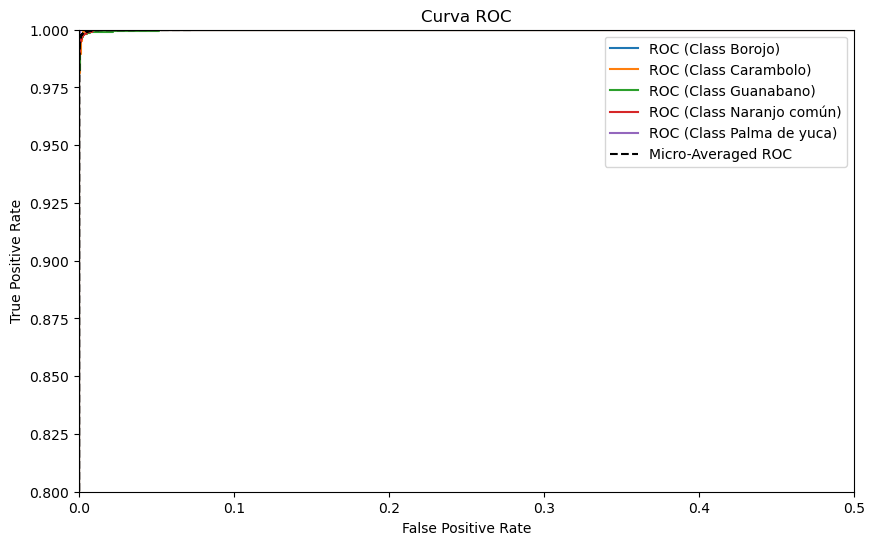

In [9]:
# Mover el modelo a la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Inicializar listas para almacenar etiquetas verdaderas y predicciones en el conjunto de validación
true_labels_val = []
predicted_scores_val = []  # Probabilidades predichas en lugar de las clases

# Evaluar el modelo en el conjunto de validación
with torch.no_grad():
    for inputs_val, labels_val in val_loader:
        inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
        outputs_val = model(inputs_val)
        true_labels_val.extend(labels_val.cpu().numpy())
        predicted_scores_val.extend(torch.nn.functional.softmax(outputs_val, dim=1).cpu().numpy())

# Calcular la curva ROC para cada clase y el AUC
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve((np.array(true_labels_val) == i).astype(int), np.array(predicted_scores_val)[:, i])
    roc_auc[class_names[i]] = auc(fpr[i], tpr[i])
    print(f'AUC (Class {class_names[i]}): {roc_auc[class_names[i]]:.4f}')

# Calcular el macro-promedio del AUC
roc_auc_macro = np.mean(list(roc_auc.values()))
print(f'Macro-AUC: {roc_auc_macro:.4f}')

# Visualizar la curva ROC
plt.figure(figsize=(10, 6))

# Graficar las curvas ROC para cada clase
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC (Class {class_names[i]})')

# Calcular el micro-AUC
fpr_micro, tpr_micro, _ = roc_curve(np.eye(num_classes)[np.array(true_labels_val)].ravel(), np.array(predicted_scores_val).ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
print(f'Micro-AUC: {roc_auc_micro:.4f}')

# Graficar la curva ROC micro-promedio
plt.plot(fpr_micro, tpr_micro, label='Micro-Averaged ROC', linestyle='--', color='black')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend()
#plt.xscale('log')
plt.xlim([0.0, 0.5])  
plt.ylim([0.8, 1.0]) 
plt.show()

# CNN
Una Convolutional Neural Network (CNN) simple es un tipo de arquitectura de red neuronal diseñada específicamente para tareas relacionadas con la visión por computadora. Se compone de capas convolucionales y capas completamente conectadas (lineales) que trabajan de manera conjunta para aprender y representar patrones en datos visuales. Tiende a ser menos eficiente en cálculos por tener mayor número de parámetros.
1. Capas Convolucionales y de Pooling:
   - Las capas convolucionales son responsables de extraer características de las imágenes mediante la aplicación de filtros que se deslizan sobre la entrada. Estos filtros aprenden patrones específicos, como bordes o texturas, en diferentes regiones de la imagen.
   - Las capas de pooling reducen gradualmente la dimensionalidad de las características, preservando la información esencial y mejorando la eficiencia computacional. El pooling se realiza generalmente mediante operaciones como el máximo o el promedio.
2. Capas Completamente Conectadas:
   - Las capas completamente conectadas toman las características extraídas por las capas convolucionales y las utilizan para realizar la clasificación o regresión final (En este caso clasificación por ser 5 especies a predecir). Cada neurona en estas capas está conectada a todas las neuronas de la capa anterior, permitiendo la integración de información global.

In [43]:
# Definir la arquitectura de la CNN
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(-1, 32 * 56 * 56)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Configurar el modelo, la función de pérdida y el optimizador
model = SimpleCNN(num_classes=5)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Número de épocas
num_epochs = 40

# Bucle de entrenamiento
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Calcular la precisión en el conjunto de validación
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Validation Accuracy: {accuracy:.2%}')

print('Entrenamiento completado.')


Epoch [1/40], Loss: 0.4499, Validation Accuracy: 89.00%
Epoch [2/40], Loss: 0.0328, Validation Accuracy: 91.18%
Epoch [3/40], Loss: 0.3936, Validation Accuracy: 94.57%
Epoch [4/40], Loss: 0.0614, Validation Accuracy: 95.35%
Epoch [5/40], Loss: 0.0196, Validation Accuracy: 95.99%
Epoch [6/40], Loss: 0.1012, Validation Accuracy: 96.77%
Epoch [7/40], Loss: 0.1286, Validation Accuracy: 96.70%
Epoch [8/40], Loss: 0.1397, Validation Accuracy: 95.41%
Epoch [9/40], Loss: 0.0383, Validation Accuracy: 95.99%
Epoch [10/40], Loss: 0.1575, Validation Accuracy: 97.43%
Epoch [11/40], Loss: 0.0211, Validation Accuracy: 94.51%
Epoch [12/40], Loss: 0.0339, Validation Accuracy: 98.06%
Epoch [13/40], Loss: 0.0053, Validation Accuracy: 96.27%
Epoch [14/40], Loss: 0.4436, Validation Accuracy: 97.16%
Epoch [15/40], Loss: 0.0055, Validation Accuracy: 96.79%
Epoch [16/40], Loss: 0.0149, Validation Accuracy: 97.35%
Epoch [17/40], Loss: 0.0145, Validation Accuracy: 98.38%
Epoch [18/40], Loss: 0.0736, Validation 

In [45]:
# Guardar el modelo 
torch.save(model, modelo_cnn_ruta)

In [6]:
# Cargar modelo       

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(-1, 32 * 56 * 56)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
model = torch.load(modelo_cnn_ruta)
model.eval()


SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=100352, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
)

In [9]:
# 6 Epocas mas con norm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load(modelo_cnn_ruta)
model.to(device)
model.train()  # Asegurarse de que el modelo esté en modo de entrenamiento

# Puedes usar el mismo optimizador y función de pérdida que usaste previamente
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Puedes seguir entrenando por más épocas
num_epochs_adicionales = 6  # Por ejemplo, entrenar por 10 épocas más
for epoch in range(num_epochs_adicionales):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Calcular la precisión en el conjunto de validación
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Epoch [{epoch + 1}/{num_epochs_adicionales}], Loss: {loss.item():.4f}, Validation Accuracy: {accuracy:.2%}')


# Guardar el modelo 
torch.save(model, modelo_cnn_ruta)

print('Entrenamiento completado.')


Epoch [1/6], Loss: 0.5818, Validation Accuracy: 81.39%
Epoch [2/6], Loss: 0.4657, Validation Accuracy: 86.83%
Epoch [3/6], Loss: 0.2185, Validation Accuracy: 89.51%
Epoch [4/6], Loss: 0.3573, Validation Accuracy: 91.71%
Epoch [5/6], Loss: 0.1203, Validation Accuracy: 93.08%
Epoch [6/6], Loss: 0.0607, Validation Accuracy: 94.52%
Entrenamiento completado.


### Eval CNN

Accuracy (Validation): 0.9841
Precision (Validation): 0.9842
Recall (Validation): 0.9841
F1-score (Validation): 0.9841
Confusion Matrix:
[[2964    0   12    3    9]
 [   2 2904   46   27    0]
 [  15   11 2975   20    3]
 [  17   20   51 2837    1]
 [   0    0    1    0 3044]]


<Figure size 1000x1000 with 0 Axes>

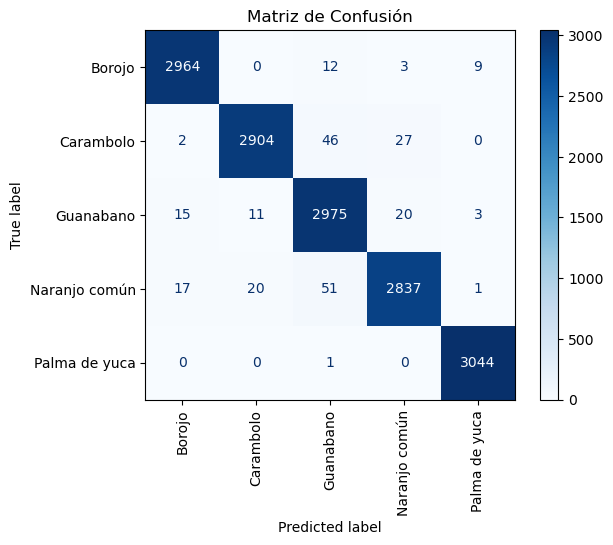

In [26]:
# Inicializa listas para almacenar etiquetas verdaderas y predicciones en el conjunto de validación
true_labels_val = []
predicted_labels_val = []

# Evaluar el modelo en el conjunto de validación
with torch.no_grad():
    for inputs_val, labels_val in val_loader:
        outputs_val = model(inputs_val)
        _, predicted_val = torch.max(outputs_val, 1)
        true_labels_val.extend(labels_val.numpy())
        predicted_labels_val.extend(predicted_val.numpy())

# Calcular métricas en el conjunto de validación
accuracy_val = accuracy_score(true_labels_val, predicted_labels_val)
precision_val = precision_score(true_labels_val, predicted_labels_val, average='weighted')
recall_val = recall_score(true_labels_val, predicted_labels_val, average='weighted')
f1_val = f1_score(true_labels_val, predicted_labels_val, average='weighted')

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(true_labels_val, predicted_labels_val)

# Imprimir métricas en el conjunto de validación
print(f'Accuracy (Validation): {accuracy_val:.4f}')
print(f'Precision (Validation): {precision_val:.4f}')
print(f'Recall (Validation): {recall_val:.4f}')
print(f'F1-score (Validation): {f1_val:.4f}')

# Imprimir la matriz de confusión
print('Confusion Matrix:')
print(conf_matrix)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 10))
display = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
display.plot(cmap='Blues', values_format='d', xticks_rotation='vertical')
plt.title('Matriz de Confusión')
plt.show()

### ROC y AOC CNN

AUC (Class Borojo): 0.9998
AUC (Class Carambolo): 0.9995
AUC (Class Guanabano): 0.9992
AUC (Class Naranjo común): 0.9992
AUC (Class Palma de yuca): 1.0000
Micro-AUC: 0.9996


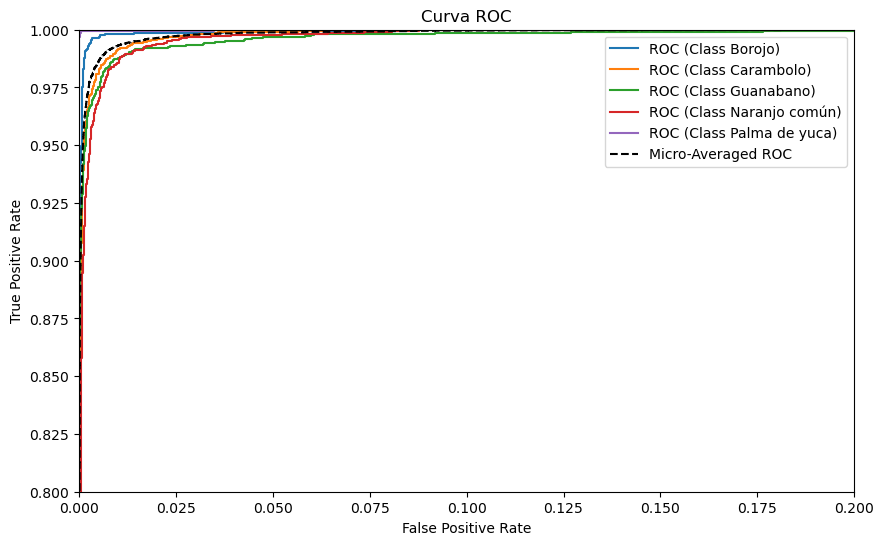

In [7]:
# Inicializa listas para almacenar etiquetas verdaderas y predicciones en el conjunto de validación
true_labels_val = []
predicted_scores_val = []  # Las probabilidades predichas en lugar de las clases

# Evaluar el modelo en el conjunto de validación
with torch.no_grad():
    for inputs_val, labels_val in val_loader:
        outputs_val = model(inputs_val)
        _, predicted_val = torch.max(outputs_val, 1)
        true_labels_val.extend(labels_val.numpy())
        predicted_scores_val.extend(torch.nn.functional.softmax(outputs_val, dim=1).numpy())

# Calcule la curva ROC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve((np.array(true_labels_val) == i).astype(int), np.array(predicted_scores_val)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calcular el micro-promedio de la curva ROC y el AUC
fpr_micro, tpr_micro, _ = roc_curve(np.eye(num_classes)[np.array(true_labels_val)].ravel(), np.array(predicted_scores_val).ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Imprimir AUC por clase
for i in range(num_classes):
    print(f'AUC (Class {class_names[i]}): {roc_auc[i]:.4f}')

# Imprimir AUC micro-promedio
print(f'Micro-AUC: {roc_auc_micro:.4f}')

# Visualizar la curva ROC
plt.figure(figsize=(10, 6))

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC (Class {class_names[i]})')

plt.plot(fpr_micro, tpr_micro, label='Micro-Averaged ROC', linestyle='--', color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend()
plt.xlim([0.0, 0.2])  # 
plt.ylim([0.8, 1.0])  # 
#plt.xscale('log')
plt.show()

# Resumen de evaluaciones
Se cargan los modelos para evaluarlos  con el conjunto de validación y se muestra:
- AUC y ROC
- Métricas


## Cargar modelos

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------------- Cargar el RandomForest -----------------------------------
modelo_randomforest = joblib.load(model_randomforest_save_path)

# ----------------------------------- Cargar modelo MobileNetV1 -----------------------------------
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride, padding=1, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class MobileNetV1(nn.Module):
    def __init__(self, num_classes=5):
        super(MobileNetV1, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            DepthwiseSeparableConv(32, 64, 1),
            nn.ReLU(inplace=True),
            DepthwiseSeparableConv(64, 128, 2),
            nn.ReLU(inplace=True),
            DepthwiseSeparableConv(128, 128, 1),
            nn.ReLU(inplace=True),
            DepthwiseSeparableConv(128, 256, 2),
            nn.ReLU(inplace=True),
            DepthwiseSeparableConv(256, 256, 1),
            nn.ReLU(inplace=True),
            DepthwiseSeparableConv(256, 512, 2),
            nn.ReLU(inplace=True),
            DepthwiseSeparableConv(512, 512, 1),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
        
modelo_mobilenetv1 = torch.load(modelo_mobilenet_ruta)
modelo_mobilenetv1 = modelo_mobilenetv1.to(device)
modelo_mobilenetv1.eval()

# ----------------------------------- Carga modelo MobileNetV2  -----------------------------------
class InvertedResidual(nn.Module):
    def __init__(self, in_channels, out_channels, stride, expand_ratio=6):
        super(InvertedResidual, self).__init__()
        hidden_dim = round(in_channels * expand_ratio)
        self.use_res_connect = stride == 1 and in_channels == out_channels

        layers = []
        if expand_ratio != 1:
            layers.append(nn.Conv2d(in_channels, hidden_dim, kernel_size=1, bias=False))
            layers.append(nn.BatchNorm2d(hidden_dim))
            layers.append(nn.ReLU6(inplace=True))
        
        layers.extend([
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=stride, padding=1, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU6(inplace=True),
            nn.Conv2d(hidden_dim, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
        ])

        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

class MobileNetV2(nn.Module):
    def __init__(self, num_classes=5, width_multiplier=1.0):
        super(MobileNetV2, self).__init__()
        # Inicializar el ancho de la red según el multiplicador de ancho
        input_channel = int(32 * width_multiplier)
        last_channel = int(1280 * width_multiplier)

        # Etapas de MobileNetV2
        features = [
            nn.Conv2d(3, input_channel, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(input_channel),
            nn.ReLU6(inplace=True),
        ]

        inverted_residual_setting = [
            # t, c, n, s (expansion factor, output channels, number of blocks, stride)
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        for t, c, n, s in inverted_residual_setting:
            output_channel = int(c * width_multiplier)
            for i in range(n):
                stride = s if i == 0 else 1
                features.append(InvertedResidual(input_channel, output_channel, stride, expand_ratio=t))
                input_channel = output_channel

        features.append(nn.Conv2d(input_channel, last_channel, kernel_size=1, bias=False))
        features.append(nn.BatchNorm2d(last_channel))
        features.append(nn.ReLU6(inplace=True))

        self.features = nn.Sequential(*features)

        # Capa de clasificación
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(last_channel, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

modelo_mobilenetv2 = torch.load( modelo_mobilenetv2_ruta)
modelo_mobilenetv2 = modelo_mobilenetv2.to(device)
modelo_mobilenetv2.eval()

# ----------------------------------- Cargar modelo SimpleCNN -----------------------------------

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(-1, 32 * 56 * 56)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
modelo_cnn = torch.load(modelo_cnn_ruta)
# Mover el modelo a la GPU
modelo_cnn = modelo_cnn.to(device)
modelo_cnn.eval()

# ----------------------------------- Carga el modelo Resnet50 -----------------------------------
modelo_r50 = resnet50(weights=None)

# Modificar la capa de salida para adaptarla a 5 clases
num_ftrs = modelo_r50.fc.in_features
modelo_r50.fc = nn.Linear(num_ftrs, 5)  # 5 clases en tu conjunto de datos

# Cargar los pesos guardados en el modelo
modelo_r50.load_state_dict(torch.load(modelo_resnet50))
modelo_r50 = modelo_r50.to(device)
modelo_r50.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [5]:
# RANDOM PREP FEATURES

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cargar una ResNet pre-entrenada y moverla a la GPU si está disponible
resnet_model = models.resnet18(pretrained=True).to(device)
# Quitar la capa de clasificación final (capa completamente conectada)
resnet_model = nn.Sequential(*list(resnet_model.children())[:-1])
# Establecer el modelo en modo de evaluación (no se entrenarán los parámetros)
resnet_model.eval()

# Definir una función para extraer características
def extract_features(loader, model):
    features = []
    labels = []
    for images, targets in loader:
        with torch.no_grad():
            # Mover las imágenes a la GPU si está disponible
            images = images.to(device, dtype=torch.float32)
            # Pasar las imágenes a través del modelo pre-entrenado
            outputs = model(images)
            # Obtener las características de la penúltima capa (antes de la capa completamente conectada)
            features.extend(outputs.squeeze().cpu().numpy())
            # Guardar las etiquetas
            labels.extend(targets.cpu().numpy())
    return features, labels

# Extraer características para el conjunto de entrenamiento y validación
train_features, train_labels = extract_features(train_loader, resnet_model)
val_features, val_labels = extract_features(val_loader, resnet_model)

C:\Users\Mosk\anaconda3\envs\entorno_dl_copy\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Mosk\anaconda3\envs\entorno_dl_copy\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## AUC y ROC
1. ROC (Receiver Operating Characteristic):
   - La Curva ROC es una representación gráfica del rendimiento de un modelo de clasificación binaria en función de su capacidad para distinguir entre las clases positiva y negativa.
   - La curva ROC se crea trazando la Tasa de Verdaderos Positivos (True Positive Rate, TPR) contra la Tasa de Falsos Positivos (False Positive Rate, FPR) a varios umbrales de decisión.
   - El eje x representa el FPR, y el eje y representa el TPR. Cada punto en la curva ROC corresponde a un umbral de clasificación diferente.

3. AUC (Área bajo la Curva):
   - El Área bajo la Curva (AUC) es una métrica numérica que resume la información de la Curva ROC en un solo valor. Cuanto mayor sea el AUC, mejor será el rendimiento del modelo.
   - La AUC varía entre 0 y 1, donde 0.5 indica un rendimiento aleatorio (como lanzar una moneda para tomar decisiones) y 1 indica un rendimiento perfecto.
   - Un AUC de 0.5 sugiere que el modelo no tiene capacidad para distinguir entre las clases, mientras que un AUC cercano a 1 indica un buen rendimiento en la discriminación entre clases.

C:\Users\Mosk\anaconda3\envs\entorno_dl_copy\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
C:\Users\Mosk\anaconda3\envs\entorno_dl_copy\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True

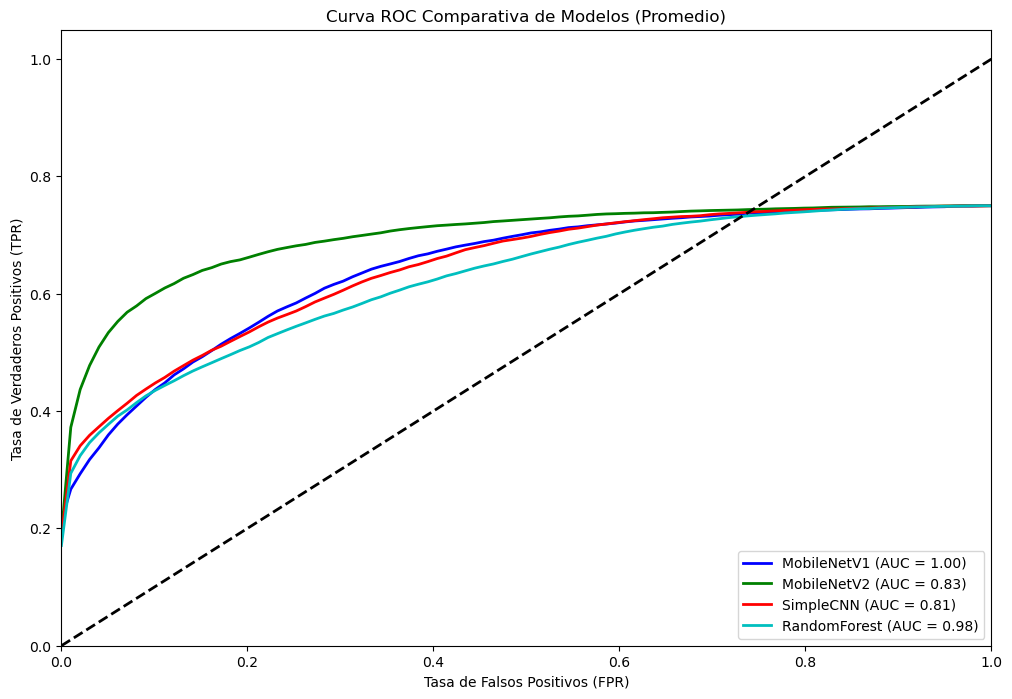

In [13]:
# BASE5
# Cargar modelos de red neuronal
models = [modelo_mobilenet, modelo_mobilenetv2, modelo_cnn]
model_names = ['MobileNetV1', 'MobileNetV2', 'SimpleCNN']

# Inicializar listas para almacenar los resultados
fprs = []
tprs = []
roc_aucs = []

# Almacenar AUCs para cada modelo
model_aucs = []

# Evaluar y calcular la curva ROC y el AUC para modelos de red neuronal
for model, model_name in zip(models, model_names):
    predictions = []
    true_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            model.eval()
            images = images.to(device, dtype=torch.float32)
            outputs = model(images)

            # Ajuste para MobileNetV2 y MobileNetV1
            if model_name == 'MobileNetV2' or model_name == 'MobileNetV1':
                predictions.append(torch.nn.functional.softmax(outputs, dim=1).cpu().numpy())
            # Ajuste para CNN
            elif model_name == 'SimpleCNN':
                predictions.append(outputs.cpu().numpy())

            true_labels.extend(labels.cpu().numpy())

        predictions = np.concatenate(predictions, axis=0)
        true_labels = np.array(true_labels)

        fpr_model = []
        tpr_model = []
        roc_auc_model = []

        if len(predictions.shape) > 1:
            for i in range(predictions.shape[1]):
                fpr, tpr, _ = roc_curve(true_labels == i, predictions[:, i])
                roc_auc = auc(fpr, tpr)
                fpr_model.append(fpr)
                tpr_model.append(tpr)
                roc_auc_model.append(roc_auc)
        else:
            fpr_model, tpr_model, _ = roc_curve(true_labels, predictions)
            roc_auc_model = auc(fpr_model, tpr_model)

        fprs.append(fpr_model)
        tprs.append(tpr_model)
        roc_aucs.append(roc_auc_model)

        # Almacenar AUC para el modelo actual
        model_aucs.append(roc_auc_model)

# Evaluar y calcular el AUC para RandomForestClassifier
rf_predictions = modelo_randomforest.predict_proba(val_features)
binarized_labels = label_binarize(val_labels, classes=np.unique(val_labels))
roc_auc_rf = roc_auc_score(binarized_labels, rf_predictions, average='macro')
fpr_rf, tpr_rf, _ = roc_curve(binarized_labels.ravel(), rf_predictions.ravel())

# Almacenar AUC para RandomForest
model_aucs.append(roc_auc_rf)
model_names.append('RandomForest')

# Calcular la curva ROC promedio para cada modelo
plt.figure(figsize=(12, 8))

colors = ['b', 'g', 'r', 'c', 'm']

for i, model_name in enumerate(model_names):
    color = colors[i]
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.zeros_like(mean_fpr)

    # Verificar que j no exceda las longitudes de las listas
    for j in range(len(models) + 1):
        if j < len(fprs) and j < len(tprs):  # Asegurarse de que el índice esté en el rango
            mean_tpr += np.interp(mean_fpr, fprs[j][i], tprs[j][i])

    mean_tpr /= len(models) + 1

    # Calcular AUC promedio
    mean_auc = np.mean(model_aucs[i])

    plt.plot(mean_fpr, mean_tpr, color=color, lw=2,
             label='{0} (AUC = {1:0.2f})'.format(model_name, mean_auc))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC Comparativa de Modelos (Promedio)')
plt.legend(loc="lower right")
plt.show()

Model: MobileNetV1, fprs length: 3, tprs length: 3
Model: MobileNetV2, fprs length: 3, tprs length: 3
Model: SimpleCNN, fprs length: 3, tprs length: 3
Model: RandomForest, fprs length: 3, tprs length: 3


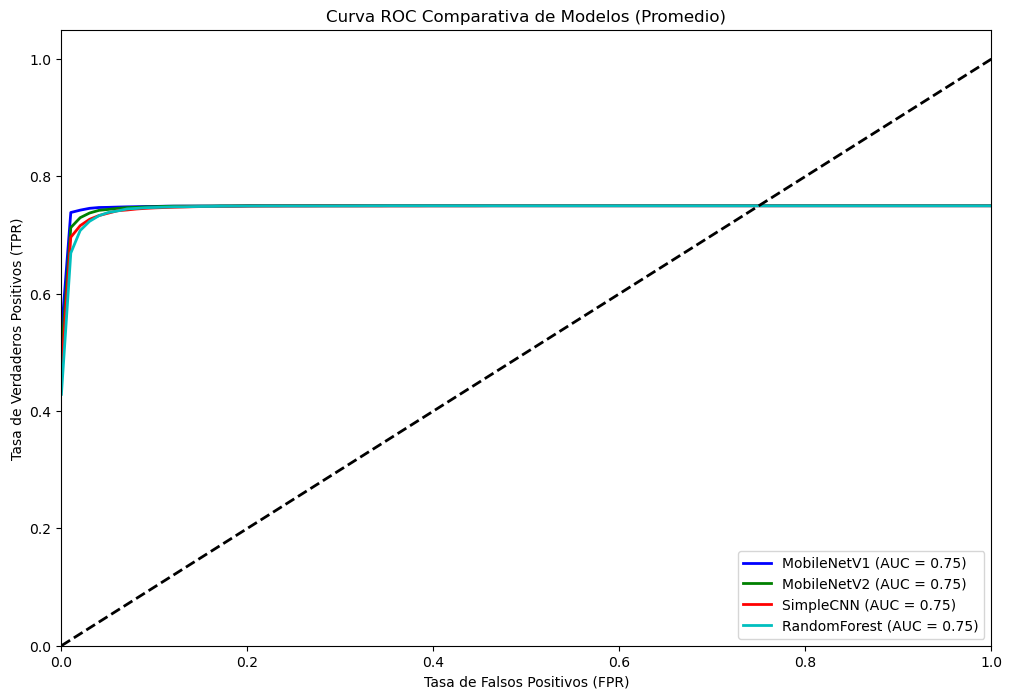

In [30]:
# BASE3
# Cargar modelos de red neuronal
models = [modelo_mobilenet, modelo_mobilenetv2, modelo_cnn]
model_names = ['MobileNetV1', 'MobileNetV2', 'SimpleCNN']

# Inicializar listas para almacenar los resultados
fprs = []
tprs = []
roc_aucs = []

# Evaluar y calcular la curva ROC y el AUC para modelos de red neuronal
for model, model_name in zip(models, model_names):
    predictions = []
    true_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            model.eval()
            images = images.to(device)  # Mover las imágenes al dispositivo correcto
            outputs = model(images)

            # Ajuste para MobileNetV2 y MobileNetV1
            if model_name == 'MobileNetV2' or model_name == 'MobileNetV1':
                predictions.append(torch.nn.functional.softmax(outputs, dim=1).cpu().numpy())
            # Ajuste para CNN
            elif model_name == 'SimpleCNN':
                predictions.append(outputs.cpu().numpy())

            true_labels.extend(labels.cpu().numpy())

    predictions = np.concatenate(predictions, axis=0)
    true_labels = np.array(true_labels)

    fpr_model = []
    tpr_model = []
    roc_auc_model = []

    if len(predictions.shape) > 1:  # Verificar si hay múltiples clases (CNN tiene más)
        for i in range(predictions.shape[1]):
            fpr, tpr, _ = roc_curve(true_labels == i, predictions[:, i])
            roc_auc = auc(fpr, tpr)
            fpr_model.append(fpr)
            tpr_model.append(tpr)
            roc_auc_model.append(roc_auc)
    else:
        fpr_model, tpr_model, _ = roc_curve(true_labels, predictions)
        roc_auc_model = auc(fpr_model, tpr_model)

    fprs.append(fpr_model)
    tprs.append(tpr_model)
    roc_aucs.append(roc_auc_model)

# ------ Evaluar y calcular el AUC para RandomForestClassifier -------
rf_predictions = modelo_randomforest.predict_proba(val_features)  # Usar las características de RandomForest

# Ajustar las etiquetas para que estén en formato binario
binarized_labels = label_binarize(val_labels, classes=np.unique(val_labels))

roc_auc_rf = roc_auc_score(binarized_labels, rf_predictions, average='macro')

# Actualizar el código para almacenar el resultado correctamente
fpr_rf, tpr_rf, _ = roc_curve(binarized_labels.ravel(), rf_predictions.ravel())
roc_aucs.append(roc_auc_rf)
model_names.append('RandomForest')

# ----- Calcular la curva ROC promedio para cada modelo -----
plt.figure(figsize=(12, 8))

colors = ['b', 'g', 'r', 'c', 'm']

for i, model_name in enumerate(model_names):
    color = colors[i]
    mean_fpr = np.linspace(0, 1, 100)  # Crear un FPR promedio uniforme
    mean_tpr = np.zeros_like(mean_fpr)

    # Agregar esta línea para verificar las longitudes
    #print(f"Model: {model_name}, fprs length: {len(fprs)}, tprs length: {len(tprs)}")

    # Verificar que j no exceda las longitudes de las listas
    for j in range(len(models) + 1):  # +1 para RandomForest
        if j < len(fprs) and j < len(tprs):  # Asegurarse de que el índice esté en el rango
            mean_tpr += np.interp(mean_fpr, fprs[j][i], tprs[j][i])

    mean_tpr /= len(models) + 1
    mean_auc = auc(mean_fpr, mean_tpr)

    plt.plot(mean_fpr, mean_tpr, color=color, lw=2,
             label='{0} (AUC = {1:0.2f})'.format(model_name, mean_auc))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC Comparativa de Modelos (Promedio)')
plt.legend(loc="lower right")
plt.show()

In [9]:
# Inicializar listas para almacenar los resultados
fprs = []
tprs = []
roc_aucs = []

# Almacenar AUCs para cada modelo
model_aucs = []

models = [modelo_mobilenet, modelo_mobilenetv2, modelo_cnn,modelo_r50]

Macro-AUC: 1.0000
Micro-AUC: 1.0000


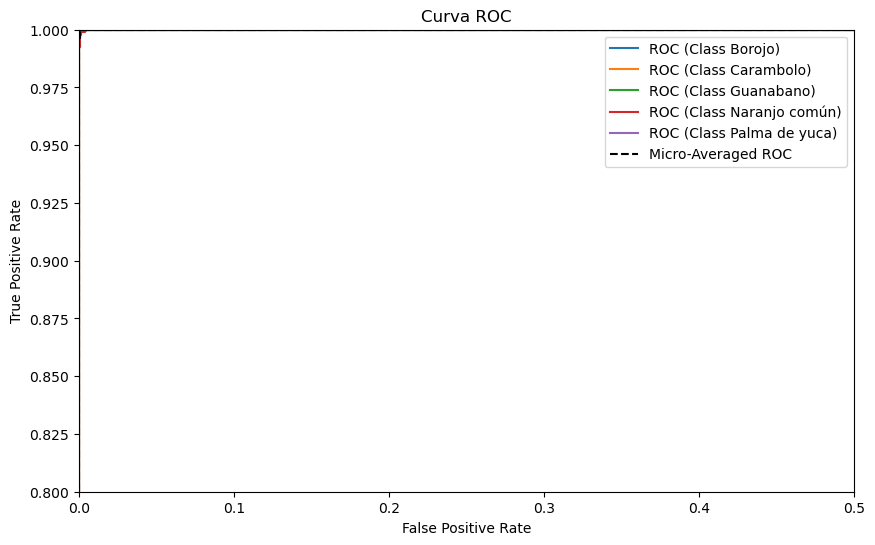

In [10]:
# -------------------
# Modelo: MobileNetV2
# -------------------
modelo_mobilenetv2.to(device)

# Inicializar listas para almacenar etiquetas verdaderas y predicciones en el conjunto de validación
true_labels_val = []
prob_predictions_mobilenetv2 = []  # Probabilidades predichas en lugar de las clases

# Evaluar el modelo en el conjunto de validación
with torch.no_grad():
    for inputs_val, labels_val in val_loader:
        inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
        outputs_val = modelo_mobilenetv2(inputs_val)
        true_labels_val.extend(labels_val.cpu().numpy())
        prob_predictions_mobilenetv2.extend(torch.nn.functional.softmax(outputs_val, dim=1).cpu().numpy())

# Obtener las etiquetas reales (y_true) de los datos de prueba
y_true_mobilenetv2 = true_labels_val

# Convertir la lista a un array de numpy
prob_predictions_mobilenetv2 = np.array(prob_predictions_mobilenetv2)

# Calcular la curva ROC y el AUC para cada clase y modelo
fpr_mobilenetv2 = dict()
tpr_mobilenetv2 = dict()
roc_auc_mobilenetv2 = dict()

for i in range(num_classes):
    fpr_mobilenetv2[i], tpr_mobilenetv2[i], _ = roc_curve(y_true_mobilenetv2, prob_predictions_mobilenetv2[:, i], pos_label=i)
    roc_auc_mobilenetv2[i] = auc(fpr_mobilenetv2[i], tpr_mobilenetv2[i])

# Almacenar AUC para el modelo actual
model_aucs.append(roc_auc_mobilenetv2)

# Almacenar los resultados para la creación del gráfico combinado
fprs.append(fpr_mobilenetv2)
tprs.append(tpr_mobilenetv2)
roc_aucs.append(roc_auc_mobilenetv2)

# Calcular el macro-promedio del AUC
roc_auc_macro = np.mean(list(roc_auc_mobilenetv2.values()))
print(f'Macro-AUC: {roc_auc_macro:.4f}')

# Visualizar la curva ROC
plt.figure(figsize=(10, 6))

# Graficar las curvas ROC para cada clase
for i in range(num_classes):
    plt.plot(fpr_mobilenetv2[i], tpr_mobilenetv2[i], label=f'ROC (Class {class_names[i]})')

# Calcular el micro-AUC
fpr_micro, tpr_micro, _ = roc_curve(np.eye(num_classes)[np.array(true_labels_val)].ravel(), np.array(prob_predictions_mobilenetv2).ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
print(f'Micro-AUC: {roc_auc_micro:.4f}')

# Graficar la curva ROC micro-promedio
plt.plot(fpr_micro, tpr_micro, label='Micro-Averaged ROC', linestyle='--', color='black')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend()
#plt.xscale('log')
plt.xlim([0.0, 0.5])  
plt.ylim([0.8, 1.0]) 
plt.show()

Macro-AUC: 0.9996
Micro-AUC: 0.9997


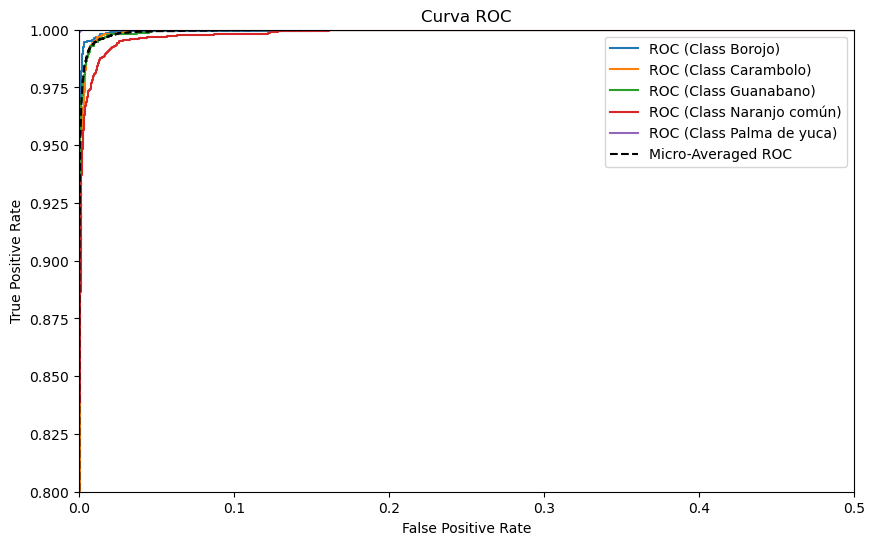

In [11]:
# -------------------
# Modelo: MobileNetV1
# -------------------
modelo_mobilenetv1.to(device)

# Inicializar listas para almacenar etiquetas verdaderas y predicciones en el conjunto de validación
true_labels_val = []
prob_predictions_mobilenetv1 = []  # Probabilidades predichas en lugar de las clases

# Evaluar el modelo en el conjunto de validación
with torch.no_grad():
    for inputs_val, labels_val in val_loader:
        inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
        outputs_val = modelo_mobilenetv1(inputs_val)
        true_labels_val.extend(labels_val.cpu().numpy())
        prob_predictions_mobilenetv1.extend(torch.nn.functional.softmax(outputs_val, dim=1).cpu().numpy())

# Obtener las etiquetas reales (y_true) de los datos de prueba
y_true_mobilenetv1 = true_labels_val

# Convertir la lista a un array de numpy
prob_predictions_mobilenetv1 = np.array(prob_predictions_mobilenetv1)

# Calcular la curva ROC y el AUC para cada clase y modelo
fpr_mobilenetv1 = dict()
tpr_mobilenetv1 = dict()
roc_auc_mobilenetv1 = dict()

for i in range(num_classes):
    fpr_mobilenetv1[i], tpr_mobilenetv1[i], _ = roc_curve(y_true_mobilenetv1, prob_predictions_mobilenetv1[:, i], pos_label=i)
    roc_auc_mobilenetv1[i] = auc(fpr_mobilenetv1[i], tpr_mobilenetv1[i])

# Almacenar AUC para el modelo actual
model_aucs.append(roc_auc_mobilenetv1)

# Almacenar los resultados para la creación del gráfico combinado
fprs.append(fpr_mobilenetv1)
tprs.append(tpr_mobilenetv1)
roc_aucs.append(roc_auc_mobilenetv1)

# Calcular el macro-promedio del AUC
roc_auc_macro = np.mean(list(roc_auc_mobilenetv1.values()))
print(f'Macro-AUC: {roc_auc_macro:.4f}')

# Visualizar la curva ROC
plt.figure(figsize=(10, 6))

# Graficar las curvas ROC para cada clase
for i in range(num_classes):
    plt.plot(fpr_mobilenetv1[i], tpr_mobilenetv1[i], label=f'ROC (Class {class_names[i]})')

# Calcular el micro-AUC
fpr_micro, tpr_micro, _ = roc_curve(np.eye(num_classes)[np.array(true_labels_val)].ravel(), np.array(prob_predictions_mobilenetv1).ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
print(f'Micro-AUC: {roc_auc_micro:.4f}')

# Graficar la curva ROC micro-promedio
plt.plot(fpr_micro, tpr_micro, label='Micro-Averaged ROC', linestyle='--', color='black')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend()
#plt.xscale('log')
plt.xlim([0.0, 0.5])  
plt.ylim([0.8, 1.0]) 
plt.show()


Macro-AUC: 0.9953
Micro-AUC: 0.9962


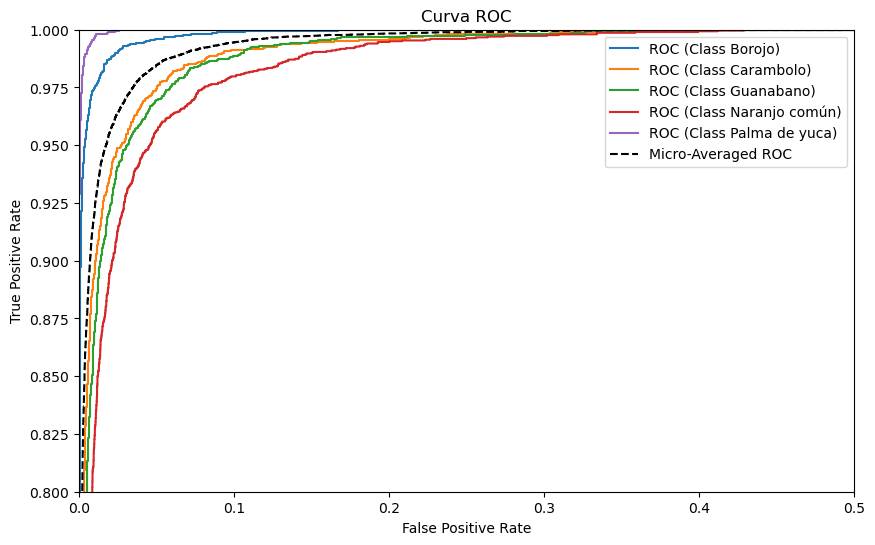

In [12]:
# -------------------
# Modelo: CNN
# -------------------
modelo_cnn.to(device)

# Inicializar listas para almacenar etiquetas verdaderas y predicciones en el conjunto de validación
true_labels_val = []
prob_predictions_cnn = []  # Probabilidades predichas en lugar de las clases

# Evaluar el modelo en el conjunto de validación
with torch.no_grad():
    for inputs_val, labels_val in val_loader:
        inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
        outputs_val = modelo_cnn(inputs_val)
        true_labels_val.extend(labels_val.cpu().numpy())
        prob_predictions_cnn.extend(torch.nn.functional.softmax(outputs_val, dim=1).cpu().numpy())

# Obtener las etiquetas reales (y_true) de los datos de prueba
y_true_cnn = true_labels_val

# Convertir la lista a un array de numpy
prob_predictions_cnn = np.array(prob_predictions_cnn)

# Calcular la curva ROC y el AUC para cada clase y modelo
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()

for i in range(num_classes):
    fpr_cnn[i], tpr_cnn[i], _ = roc_curve(y_true_cnn, prob_predictions_cnn[:, i], pos_label=i)
    roc_auc_cnn[i] = auc(fpr_cnn[i], tpr_cnn[i])

# Almacenar AUC para el modelo actual
model_aucs.append(roc_auc_cnn)

# Almacenar los resultados para la creación del gráfico combinado
fprs.append(fpr_cnn)
tprs.append(tpr_cnn)
roc_aucs.append(roc_auc_cnn)

# Calcular el macro-promedio del AUC
roc_auc_macro = np.mean(list(roc_auc_cnn.values()))
print(f'Macro-AUC: {roc_auc_macro:.4f}')

# Visualizar la curva ROC
plt.figure(figsize=(10, 6))

# Graficar las curvas ROC para cada clase
for i in range(num_classes):
    plt.plot(fpr_cnn[i], tpr_cnn[i], label=f'ROC (Class {class_names[i]})')

# Calcular el micro-AUC
fpr_micro, tpr_micro, _ = roc_curve(np.eye(num_classes)[np.array(true_labels_val)].ravel(), np.array(prob_predictions_cnn).ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
print(f'Micro-AUC: {roc_auc_micro:.4f}')

# Graficar la curva ROC micro-promedio
plt.plot(fpr_micro, tpr_micro, label='Micro-Averaged ROC', linestyle='--', color='black')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend()
#plt.xscale('log')
plt.xlim([0.0, 0.5])  
plt.ylim([0.8, 1.0]) 
plt.show()


Macro-AUC: 1.0000
Micro-AUC: 1.0000


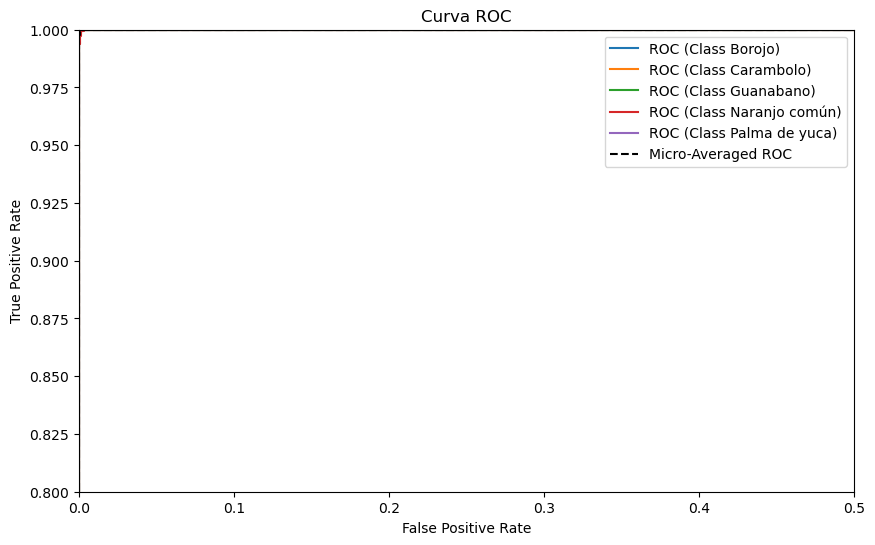

In [13]:
# -------------------
# Modelo: r50
# -------------------
modelo_r50.to(device)

# Inicializar listas para almacenar etiquetas verdaderas y predicciones en el conjunto de validación
true_labels_val = []
prob_predictions_r50 = []  # Probabilidades predichas en lugar de las clases

# Evaluar el modelo en el conjunto de validación
with torch.no_grad():
    for inputs_val, labels_val in val_loader:
        inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)
        outputs_val = modelo_r50(inputs_val)
        true_labels_val.extend(labels_val.cpu().numpy())
        prob_predictions_r50.extend(torch.nn.functional.softmax(outputs_val, dim=1).cpu().numpy())

# Obtener las etiquetas reales (y_true) de los datos de prueba
y_true_r50 = true_labels_val

# Convertir la lista a un array de numpy
prob_predictions_r50 = np.array(prob_predictions_r50)

# Calcular la curva ROC y el AUC para cada clase y modelo
fpr_r50 = dict()
tpr_r50 = dict()
roc_auc_r50 = dict()

for i in range(num_classes):
    fpr_r50[i], tpr_r50[i], _ = roc_curve(y_true_r50, prob_predictions_r50[:, i], pos_label=i)
    roc_auc_r50[i] = auc(fpr_r50[i], tpr_r50[i])

# Almacenar AUC para el modelo actual
model_aucs.append(roc_auc_r50)

# Almacenar los resultados para la creación del gráfico combinado
fprs.append(fpr_r50)
tprs.append(tpr_r50)
roc_aucs.append(roc_auc_r50)

# Calcular el macro-promedio del AUC
roc_auc_macro = np.mean(list(roc_auc_r50.values()))
print(f'Macro-AUC: {roc_auc_macro:.4f}')

# Visualizar la curva ROC
plt.figure(figsize=(10, 6))

# Graficar las curvas ROC para cada clase
for i in range(num_classes):
    plt.plot(fpr_r50[i], tpr_r50[i], label=f'ROC (Class {class_names[i]})')

# Calcular el micro-AUC
fpr_micro, tpr_micro, _ = roc_curve(np.eye(num_classes)[np.array(true_labels_val)].ravel(), np.array(prob_predictions_r50).ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
print(f'Micro-AUC: {roc_auc_micro:.4f}')

# Graficar la curva ROC micro-promedio
plt.plot(fpr_micro, tpr_micro, label='Micro-Averaged ROC', linestyle='--', color='black')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend()
#plt.xscale('log')
plt.xlim([0.0, 0.5])  
plt.ylim([0.8, 1.0]) 
plt.show()


Macro-AUC: 0.9856
Micro-AUC: 0.9882


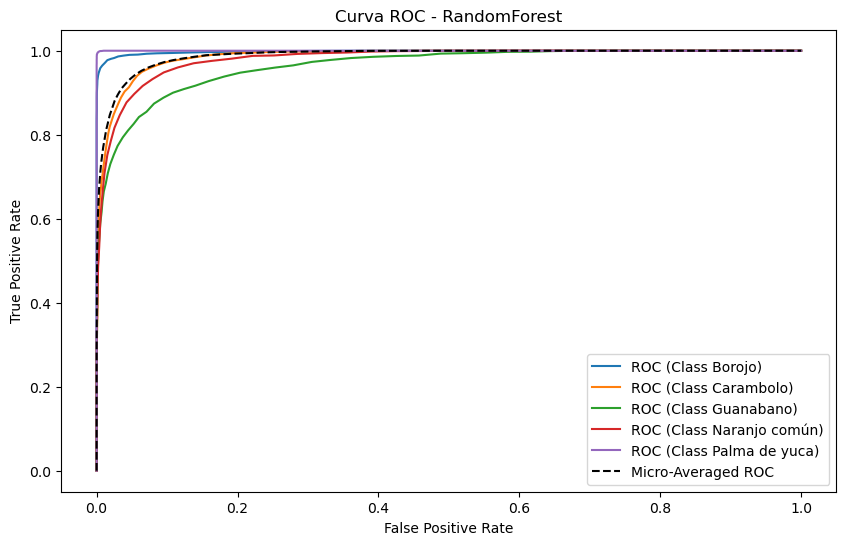

In [15]:
# -------------------
# Modelo: RANDOMFOREST
# -------------------
# Obtener las probabilidades de predicción en lugar de las clases
predicted_scores_val_rf = modelo_randomforest.predict_proba(val_features)

# Binarizar las etiquetas verdaderas
true_labels_val_bin = label_binarize(val_labels, classes=range(num_classes))

# Inicializar variables para almacenar la tasa de falsos positivos, la tasa de verdaderos positivos y el AUC
fpr_rf = dict()
tpr_rf = dict()
roc_auc_rf = dict()

# Calcular la curva ROC para cada clase y el AUC
for i in range(num_classes):
    fpr_rf[i], tpr_rf[i], _ = roc_curve(true_labels_val_bin[:, i], predicted_scores_val_rf[:, i])
    roc_auc_rf[class_names[i]] = auc(fpr_rf[i], tpr_rf[i])
    #print(f'AUC (Class {class_names[i]}): {roc_auc_rf[class_names[i]]:.4f}')

# Calcular el macro-promedio del AUC
roc_auc_macro_rf = np.mean(list(roc_auc_rf.values()))
print(f'Macro-AUC: {roc_auc_macro_rf:.4f}')

# Calcular el micro-AUC
fpr_micro_rf, tpr_micro_rf, _ = roc_curve(true_labels_val_bin.ravel(), predicted_scores_val_rf.ravel())
roc_auc_micro_rf = auc(fpr_micro_rf, tpr_micro_rf)
print(f'Micro-AUC: {roc_auc_micro_rf:.4f}')

# Almacenar AUC para el modelo actual
model_aucs.append(roc_auc_rf)

# Almacenar los resultados para la creación del gráfico combinado
fprs.append(fpr_rf)
tprs.append(tpr_rf)
roc_aucs.append(roc_auc_rf)

# Visualizar la curva ROC
plt.figure(figsize=(10, 6))

# Graficar las curvas ROC para cada clase
for i in range(num_classes):
    plt.plot(fpr_rf[i], tpr_rf[i], label=f'ROC (Class {class_names[i]})')

# Graficar la curva ROC micro-promedio
plt.plot(fpr_micro_rf, tpr_micro_rf, label='Micro-Averaged ROC', linestyle='--', color='black')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - RandomForest')
plt.legend()
plt.show()


In [23]:
# -------------------
# Crear el gráfico ROC combinado para todos los modelos
# -------------------
model_names = ['MobileNetV1', 'MobileNetV2', 'SimpleCNN', 'ResNet50','RandomForest']
plt.figure(figsize=(12, 8))

colors = ['b', 'g', 'r', 'c', 'm']

# Iterar sobre los modelos y sus resultados
for i, model_name in enumerate(model_names):
    color = colors[i]
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.zeros_like(mean_fpr)

    # Verificar que j no exceda las longitudes de las listas
    for j in range(len(models) + 1):
        if j < len(fprs) and j < len(tprs):  # Asegurarse de que el índice esté en el rango
            mean_tpr += np.interp(mean_fpr, fprs[j][i], tprs[j][i])

    mean_tpr /= len(models) + 1

    # Calcular AUC promedio
    mean_auc = np.mean(model_aucs, axis=0)[i] #np.mean(model_aucs[i])

    plt.plot(mean_fpr, mean_tpr, color=color, lw=2,
             label='{0} (AUC = {1:0.2f})'.format(model_name, mean_auc))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.6, 1.0])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC Comparativa de Modelos (Promedio)')
plt.legend(loc="lower right")
plt.show()

TypeError: unsupported operand type(s) for +: 'dict' and 'dict'

<Figure size 1200x800 with 0 Axes>

## Métricas 'classification report' Y matriz confusión
1. *Precision (Precisión)*:
   - Precision se refiere a la proporción de instancias positivas predichas correctamente con respecto a todas las instancias positivas predichas (verdaderos positivos más falsos positivos).
   - Precision mide la exactitud de las predicciones positivas del modelo.
   - De las instancias que el modelo predijo como positivas, ¿cuántas eran realmente positivas?
2. *Recall (Recuperación o Sensibilidad)*:
   - Recall se refiere a la proporción de instancias positivas predichas correctamente con respecto a todas las instancias positivas reales (verdaderos positivos más falsos negativos).
   - Recall mide la capacidad del modelo para capturar todas las instancias positivas.
   - De todas las instancias positivas reales, ¿cuántas pudo capturar el modelo?
3. *F1-Score*:
   - F1-Score es la media armónica de Precision y Recall. Proporciona un equilibrio entre Precision y Recall, siendo especialmente útil cuando hay un desequilibrio en las clases.
4. *Matriz de Confusión*:
   - La Matriz de Confusión es una tabla que muestra la cantidad de verdaderos positivos (TP), verdaderos negativos (TN), falsos positivos (FP) y falsos negativos (FN).

Reporte de Clasificación:
               precision    recall  f1-score   support

       Borojo       0.98      0.96      0.97      2983
    Carambolo       0.86      0.90      0.88      2967
    Guanabano       0.76      0.89      0.82      3003
Naranjo común       0.92      0.75      0.83      2978
Palma de yuca       1.00      0.99      0.99      3031

     accuracy                           0.90     14962
    macro avg       0.90      0.90      0.90     14962
 weighted avg       0.91      0.90      0.90     14962



<Figure size 1000x1000 with 0 Axes>

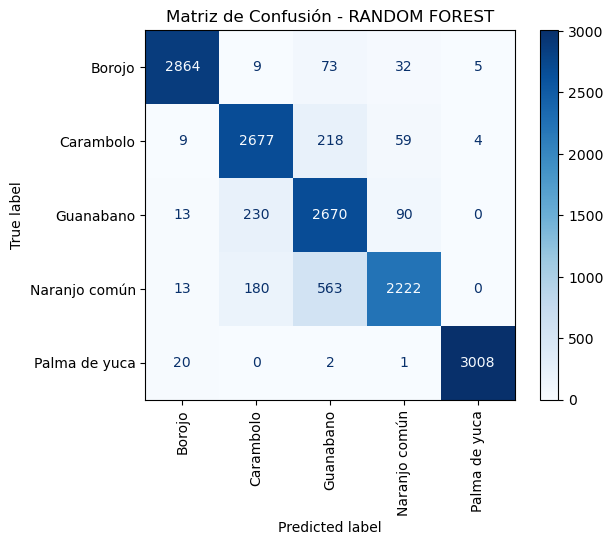

In [7]:
#RF
# Evaluar el modelo RandomForest en el conjunto de validación
predicted_labels_val_rf = modelo_randomforest.predict(val_features)

# Calcular la matriz de confusión
conf_matrix_rf = confusion_matrix(val_labels, predicted_labels_val_rf) #

# Generar y mostrar el classification_report
reporte_clasificacion = classification_report(val_labels, predicted_labels_val_rf,target_names=class_names)
print("Reporte de Clasificación:")
print(reporte_clasificacion)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 10))
display_rf = ConfusionMatrixDisplay(conf_matrix_rf, display_labels=class_names)
display_rf.plot(cmap='Blues', values_format='d', xticks_rotation='vertical')
plt.title('Matriz de Confusión - RANDOM FOREST')
plt.show()

Reporte de Clasificación en el conjunto de validación:
               precision    recall  f1-score   support

       Borojo       1.00      0.99      0.99      2983
    Carambolo       0.98      0.98      0.98      2967
    Guanabano       0.97      0.99      0.98      3003
Naranjo común       0.98      0.97      0.97      2978
Palma de yuca       1.00      1.00      1.00      3031

     accuracy                           0.99     14962
    macro avg       0.99      0.99      0.99     14962
 weighted avg       0.99      0.99      0.99     14962


Matriz de Confusión:
[[2940    2   19   20    2]
 [   1 2922   29   15    0]
 [   0   15 2971   15    2]
 [   8   43   50 2877    0]
 [   1    0    0    0 3030]]


<Figure size 1000x1000 with 0 Axes>

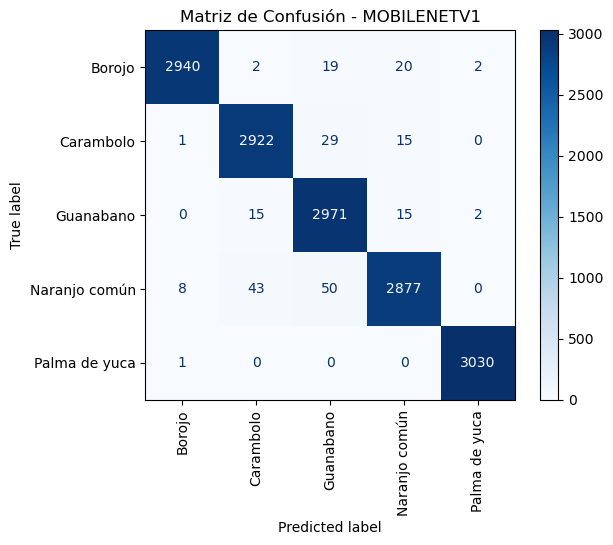

In [9]:
#MOBILENETV1
# Mover el modelo a la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelo_mobilenetv1.to(device)

# Inicializa listas para almacenar etiquetas verdaderas y predicciones en el conjunto de validación
true_labels_val = []
predicted_labels_val = []

# Evaluar el modelo en el conjunto de validación
modelo_mobilenetv1.eval()
with torch.no_grad():
    for inputs_val, labels_val in val_loader:
        inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)  # Mover datos a la GPU si es necesario
        outputs_val = modelo_mobilenetv1(inputs_val)
        _, predicted_val = torch.max(outputs_val, 1)
        true_labels_val.extend(labels_val.cpu().numpy())
        predicted_labels_val.extend(predicted_val.cpu().numpy())

# Calcular el classification_report en el conjunto de validación
reporte_clasificacion = classification_report(true_labels_val, predicted_labels_val,target_names=class_names)

# Calcular la matriz de confusión
matriz_confusion = confusion_matrix(true_labels_val, predicted_labels_val)

# Imprimir el classification_report
print("Reporte de Clasificación en el conjunto de validación:")
print(reporte_clasificacion)

print("\nMatriz de Confusión:")
print(matriz_confusion)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 10))
display_rf = ConfusionMatrixDisplay(matriz_confusion, display_labels=class_names)
display_rf.plot(cmap='Blues', values_format='d', xticks_rotation='vertical')
plt.title('Matriz de Confusión - MOBILENETV1')
plt.show()

Reporte de Clasificación en el conjunto de validación:
               precision    recall  f1-score   support

       Borojo       1.00      1.00      1.00      2983
    Carambolo       0.99      0.99      0.99      2967
    Guanabano       1.00      1.00      1.00      3003
Naranjo común       0.99      1.00      0.99      2978
Palma de yuca       1.00      1.00      1.00      3031

     accuracy                           1.00     14962
    macro avg       1.00      1.00      1.00     14962
 weighted avg       1.00      1.00      1.00     14962


Matriz de Confusión:
[[2979    0    2    2    0]
 [   0 2952    0   15    0]
 [   2    4 2991    6    0]
 [   0   11    0 2967    0]
 [   0    1    2    0 3028]]


<Figure size 1000x1000 with 0 Axes>

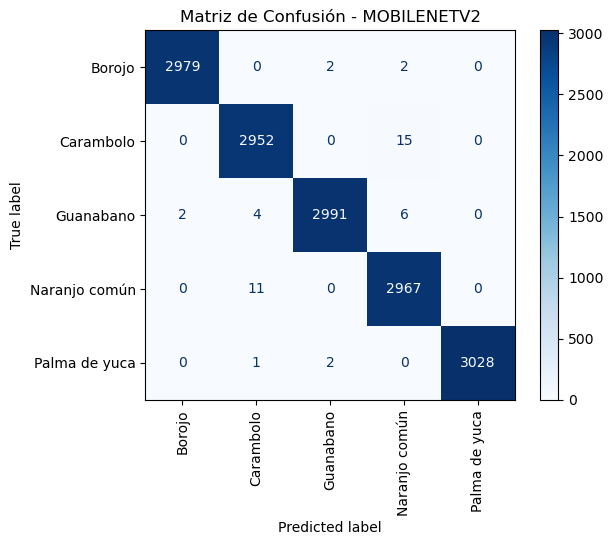

In [10]:
#MOBILENETV2
# Mover el modelo a la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelo_mobilenetv2.to(device)

# Inicializa listas para almacenar etiquetas verdaderas y predicciones en el conjunto de validación
true_labels_val = []
predicted_labels_val = []

# Evaluar el modelo en el conjunto de validación
modelo_mobilenetv2.eval()
with torch.no_grad():
    for inputs_val, labels_val in val_loader:
        inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)  # Mover datos a la GPU si es necesario
        outputs_val = modelo_mobilenetv2(inputs_val)
        _, predicted_val = torch.max(outputs_val, 1)
        true_labels_val.extend(labels_val.cpu().numpy())
        predicted_labels_val.extend(predicted_val.cpu().numpy())

# Calcular el classification_report en el conjunto de validación
reporte_clasificacion = classification_report(true_labels_val, predicted_labels_val,target_names=class_names)

# Calcular la matriz de confusión
matriz_confusion = confusion_matrix(true_labels_val, predicted_labels_val)

# Imprimir el classification_report
print("Reporte de Clasificación en el conjunto de validación:")
print(reporte_clasificacion)

print("\nMatriz de Confusión:")
print(matriz_confusion)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 10))
display_rf = ConfusionMatrixDisplay(matriz_confusion, display_labels=class_names)
display_rf.plot(cmap='Blues', values_format='d', xticks_rotation='vertical')
plt.title('Matriz de Confusión - MOBILENETV2')
plt.show()

Reporte de Clasificación en el conjunto de validación:
               precision    recall  f1-score   support

       Borojo       0.96      0.98      0.97      2983
    Carambolo       0.94      0.93      0.94      2967
    Guanabano       0.91      0.93      0.92      3003
Naranjo común       0.93      0.90      0.91      2978
Palma de yuca       0.99      0.99      0.99      3031

     accuracy                           0.95     14962
    macro avg       0.95      0.95      0.94     14962
 weighted avg       0.95      0.95      0.95     14962


Matriz de Confusión:
[[2915    1   17   23   27]
 [   5 2751  111  100    0]
 [  43   67 2803   85    5]
 [  54   93  160 2670    1]
 [  19    5    4    0 3003]]


<Figure size 1000x1000 with 0 Axes>

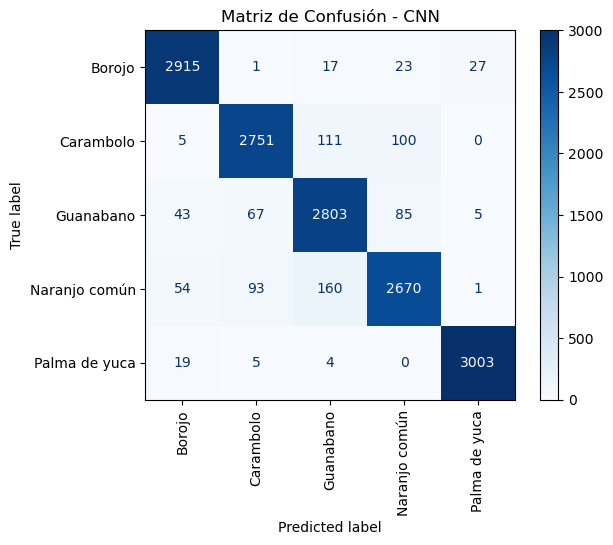

In [11]:
#CNN
# Mover el modelo a la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelo_cnn.to(device)

# Evaluar el modelo en el conjunto de validación
with torch.no_grad():
    true_labels_val = []
    predicted_labels_val = []

    for inputs_val, labels_val in val_loader:
        inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)  # Mover datos a la GPU si es necesario
        outputs_val = modelo_cnn(inputs_val)
        _, predicted_val = torch.max(outputs_val, 1)
        true_labels_val.extend(labels_val.cpu().numpy())
        predicted_labels_val.extend(predicted_val.cpu().numpy())

# Calcular el classification_report en el conjunto de validación
reporte_clasificacion = classification_report(true_labels_val, predicted_labels_val,target_names=class_names)

# Calcular la matriz de confusión
matriz_confusion = confusion_matrix(true_labels_val, predicted_labels_val)

# Imprimir el classification_report
print("Reporte de Clasificación en el conjunto de validación:")
print(reporte_clasificacion)

print("\nMatriz de Confusión:")
print(matriz_confusion)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 10))
display_rf = ConfusionMatrixDisplay(matriz_confusion, display_labels=class_names)
display_rf.plot(cmap='Blues', values_format='d', xticks_rotation='vertical')
plt.title('Matriz de Confusión - CNN')
plt.show()

Reporte de Clasificación en el conjunto de validación:
               precision    recall  f1-score   support

       Borojo       1.00      1.00      1.00      2983
    Carambolo       1.00      1.00      1.00      2967
    Guanabano       1.00      1.00      1.00      3003
Naranjo común       1.00      1.00      1.00      2978
Palma de yuca       1.00      1.00      1.00      3031

     accuracy                           1.00     14962
    macro avg       1.00      1.00      1.00     14962
 weighted avg       1.00      1.00      1.00     14962


Matriz de Confusión:
[[2982    0    1    0    0]
 [   0 2961    2    4    0]
 [   0    1 3002    0    0]
 [   1    3    3 2971    0]
 [   0    0    0    0 3031]]


<Figure size 1000x1000 with 0 Axes>

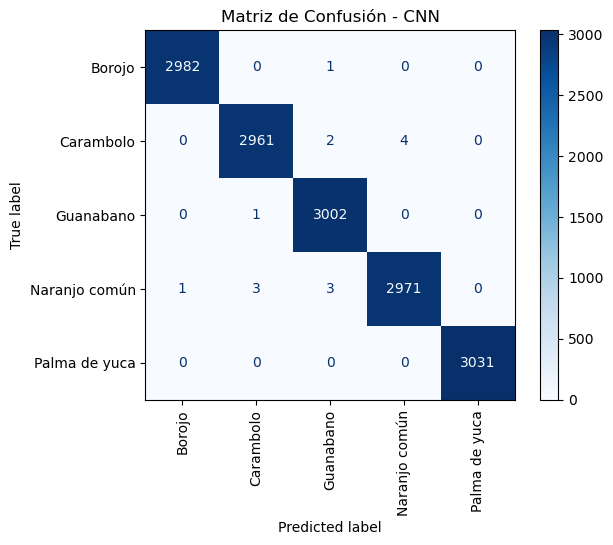

In [12]:
#RESNET50
# Mover el modelo a la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelo_r50.to(device)

# Evaluar el modelo en el conjunto de validación
with torch.no_grad():
    true_labels_val = []
    predicted_labels_val = []

    for inputs_val, labels_val in val_loader:
        inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)  # Mover datos a la GPU si es necesario
        outputs_val = modelo_r50(inputs_val)
        _, predicted_val = torch.max(outputs_val, 1)
        true_labels_val.extend(labels_val.cpu().numpy())
        predicted_labels_val.extend(predicted_val.cpu().numpy())

# Calcular el classification_report en el conjunto de validación
reporte_clasificacion = classification_report(true_labels_val, predicted_labels_val, target_names=class_names)

# Calcular la matriz de confusión
matriz_confusion = confusion_matrix(true_labels_val, predicted_labels_val)

# Imprimir el classification_report y la matriz de confusión
print("Reporte de Clasificación en el conjunto de validación:")
print(reporte_clasificacion)

print("\nMatriz de Confusión:")
print(matriz_confusion)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 10))
display_rf = ConfusionMatrixDisplay(matriz_confusion, display_labels=class_names)
display_rf.plot(cmap='Blues', values_format='d', xticks_rotation='vertical')
plt.title('Matriz de Confusión - CNN')
plt.show()